<a href="https://colab.research.google.com/github/fdamata/pucrj-machinelearning-mvp-ml/blob/main/mvp_sprint_02_fma_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### MVP Machine Learning & Analytics

**Nome:** Fabiano da Mata Almeida<br>
**Matrícula:** 4052025000952<br>
**Dataset:** Pressão de Vapor da nafta.

**Nota sobre confidencialidade e descaracterização dos dados:**  
> Para garantir a confidencialidade e o respeito à privacidade, todos os dados utilizados neste estudo foram devidamente descaracterizados, não permitindo a identificação na sua unidade de medida original ou informações sensíveis.<br>
O uso desse dataset segue as boas práticas de ética em ciência de dados, assegurando que nenhuma informação pessoal ou confidencial seja exposta durante as análises.

# 1. Escopo, Objetivo e Definição do Problema

## 1.1. Contexto do problema e objetivo

O conjunto de dados **Pressão de Vapor da Nafta** contempla observações de uma corrente do processo de fracionamento do petróleo, contendo variáveis físico-químicas do processo e propriedades da corrente.

A variável alvo representa a pressão exercida pelo vapor em equilíbrio com sua fase líquida a uma temperatura específica. Essa propriedade caracteriza a volatilidade da corrente, impactando requisitos de armazenamento, segurança, transporte e conformidade regulatória.

**Objetivo:** Desenvolver um modelo preditivo para estimar a pressão de vapor da nafta com precisão, permitindo operação próxima ao limite superior da especificação sem comprometer a segurança.

*Nota: O conjunto de dados foi previamente analisado na SPRINT de Análise de Dados e Boas Práticas, permitindo uma Análise Exploratória dod Dados simplificada.*

## 1.2. Tipo de tarefa

Estudo de **regressão** com dados tabulares originados de sensores industriais e ensaios laboratoriais, aplicado à engenharia de processos na formulação de gasolina automotiva.

A tarefa envolve desenvolvimento de modelo supervisionado para predição contínua de propriedade físico-química crítica.

## 1.3. Valor para o negócio/usuário

**Ganho econômico:** A predição confiável permite incorporar frações mais pesadas do GLP à nafta, agregando valor significativo (GLP vale ~50% da gasolina por volume).

**Aplicações operacionais:**
- Otimização de parâmetros operacionais em tempo real
- Integração em sistemas de controle preditivo multivariável (MPC)
- Automação da gestão da propriedade

**Beneficiários:** Engenharia de Processos, Operações Industriais e Segurança Operacional, através de maior eficiência, previsibilidade e controle de qualidade.


# 2. Reprodutibilidade e ambiente

Esta seção consolida todas as importações de bibliotecas necessárias, definições das funções utilizadas e algumas configurações iniciais globais.

## 2.1. Dependências
Instalação de pacotes que permitam a utilização de todo o notebook (pacotes extras). <br>

In [1]:
# # Exemplo: descomente o que precisar
!pip install -q catboost
!pip install -q scikit-optimize
# !pip install -q xgboost lightgbm statsmodels
# !pip install -q openpyxl tabulate

## 2.2. Importações
Importações de bibliotecas. <br>

In [2]:
# Bibliotecas básicas
import time, ast, sys, joblib, math, os, json, importlib, random
from copy import deepcopy
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

# Visualização
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate
from IPython.display import Image, display

# Análise estatística
from scipy.stats import norm, kstest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning - Seleção de algoritmos, avaliação e modelagem
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler #, RobustScaler, Normalizer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb

from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback, TimerCallback, DeltaYStopper
from skopt.plots import plot_objective, plot_convergence, plot_evaluations, plot_histogram, plot_objective_2D, plot_regret, plot_gaussian_process

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Configurações de exibição
pd.options.display.float_format = '{:.4f}'.format  # Define o formato de exibição dos números float no pandas para quatro casas decimais
pd.set_option('display.expand_frame_repr', False)  # Não quebra a representação do dataframe
np.set_printoptions(precision=8, suppress=True, floatmode='maxprec') # Define o formato de exibição dos números float no numpy para oito casas decimais e sem notação científica

## 2.3. Definições prévias do problema
Definições padronizadas que serão utilizadas ao longo de todo o problema.

In [3]:
# Definição do problema e inicialização de parâmetros
PROBLEM_TYPE = "regressao"
SEED = 69 # Garantia de reprodutibilidade
SPLIT = 0.35 # Percentual de dados para teste
CV_FOLDS = 10 # Número de folds para validação cruzada
METRIC_TO_OPT = 'rmse'  # Métrica para regressão. Pode ser 'r2', 'rmse', ou 'mae'

MINIMIZE_METRICS = {'rmse', 'mae', 'mse', 'msle', 'rmsle', 'mape', 'poisson', 'gamma', 'max_error', 'medae'} # Métricas que devem ser minimizadas
MAXIMIZE_METRICS = {'r2', 'var', 'd2', 'explained_variance'} # Métricas que devem ser maximizadas

np.random.seed(SEED)
random.seed(SEED)

Mais adiante no trabalho há um melhor detalhamento das escolhas.

## 2.4. Funções Python
Definição de funções utilizadas no projeto. <br>

In [4]:
# Declaração de funções

def teste_n(df, column_name, alpha=0.05): # Função para realização de teste de normalidade dos dados segundo Kolmogorov-Smirnov
    """
    Executa o teste de Kolmogorov-Smirnov para verificar se uma coluna do DataFrame segue uma distribuição normal.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    column_name : str
        Nome da coluna a ser testada quanto à normalidade.
    alpha : float, opcional
        Nível de significância para o teste. O padrão é 0.05 (5%).

    Descrição:
    ----------
    - Normaliza os dados da coluna (subtrai a média e divide pelo desvio padrão).
    - Aplica o teste de Kolmogorov-Smirnov comparando com uma distribuição normal padrão.
    - Interpreta os resultados com base no p-valor e o nível de significância especificado.
    - Exibe uma mensagem informando se a distribuição pode ser considerada normal ou não.

    Retorno:
    --------
    tuple
        Uma tupla contendo (estatística do teste, p-valor).

    Exemplo de uso:
    --------------
    stat, p_valor = teste_n(df, 'pv_nafta')
    stat, p_valor = teste_n(df, 'pv_nafta', alpha=0.01)  # Usando significância de 1%
    """
    # Executar o teste de Kolmogorov-Smirnov - nesse caso em relação a uma distribuição normal
    stat, p_valor = kstest((df[column_name] - np.mean(df[column_name])) / np.std(df[column_name], ddof=1), 'norm')

    # Interpretar os resultados
    if p_valor > alpha:
        print("A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor:", f"{p_valor:.5f}")
    else:
        print("A amostra não parece vir de uma distribuição normal (rejeitamos a hipótese nula) p-valor:", f"{p_valor:.5f}")
    return float(stat), float(p_valor)

def calcula_corr(df): # Função para cálculo e visualização da matriz de correlação
    """
    Calcula e visualiza a matriz de correlação absoluta entre as variáveis de um DataFrame.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados para cálculo da correlação.

    Descrição:
    ----------
    - Remove valores NaN do DataFrame antes de calcular as correlações.
    - Calcula a matriz de correlação absoluta entre todas as variáveis.
    - Cria uma visualização interativa usando Plotly Express.
    - Aplica uma escala de cores Viridis para representar a intensidade das correlações.
    - Mostra os valores numéricos das correlações com duas casas decimais.

    Exemplo de uso:
    --------------
    calcula_corr(df)
    calcula_corr(df[selected_columns])  # Para um subconjunto de colunas
    """
    df_corr = df.dropna().corr().abs()

    fig = px.imshow(
        img    = df_corr,
        color_continuous_scale='Viridis',
        width  = 900, # caso não esteja visualizando todas as variáveis, altere esse valor
        height = 900, # caso não esteja visualizando todas as variáveis, altere esse valor
        text_auto = ".2f"  # Mostra os valores com 2 casas decimais
    )

    fig.update_traces(textfont_size=12)  # Altere o valor conforme desejado
    fig.show()

def pairplot_corr_hm(df, figsize=(12, 12), hist_bins=30, s=10, alpha=0.6): # Função para pairplot com correlação
    """
    Cria um pairplot onde a cor dos pontos é baseada na correlação absoluta entre variáveis
    usando uma paleta de cores Viridis.

    Parâmetros:
    -----------
    df : pandas DataFrame
        O DataFrame contendo os dados a serem plotados
    figsize : tuple, opcional
        Tamanho da figura (largura, altura) em polegadas
    hist_bins : int, opcional
        Número de bins para os histogramas na diagonal
    s : int, opcional
        Tamanho dos pontos nos gráficos de dispersão
    alpha : float, opcional
        Nível de transparência dos pontos (0-1)
    """

    # Obter a matriz de correlação absoluta
    corr_matrix = df.corr().abs()

    # Configurar a normalização de cores para a escala viridis
    norm = Normalize(vmin=0, vmax=1)

    # Obter as variáveis e o número de variáveis
    variables = df.columns
    n_vars = len(variables)

    # Criar a figura e os subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)

    # Ajustar o espaçamento entre os subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # Criar os gráficos para cada par de variáveis
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            ax = axes[i, j]

            # Remover os ticks dos eixos internos
            if i < n_vars - 1:
                ax.set_xticks([])
            if j > 0:
                ax.set_yticks([])

            # Se estamos na diagonal, plotar histograma
            if i == j:
                ax.hist(df[var1], bins=hist_bins, alpha=0.7, color='darkblue')
                ax.set_title(var1, fontsize=10)
            else:
                # Obter a correlação absoluta entre as variáveis
                corr_val = corr_matrix.loc[var1, var2]

                # Determinar a cor com base na correlação
                color = viridis(norm(corr_val))

                # Criar o gráfico de dispersão
                ax.scatter(df[var2], df[var1], s=s, alpha=alpha, color=color)

                # Adicionar a correlação como texto no gráfico
                ax.text(0.05, 0.95, f'|ρ|: {corr_val:.2f}',
                        transform=ax.transAxes, fontsize=8,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Adicionar os nomes das variáveis apenas nos eixos externos
    for i, var in enumerate(variables):
        axes[n_vars-1, i].set_xlabel(var, fontsize=10)
        axes[i, 0].set_ylabel(var, fontsize=10)

    # Adicionar uma barra de cores para referência
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="viridis"), cax=cbar_ax)
    cb.set_label('Correlação Absoluta |ρ|')

    plt.suptitle('Pairplot com Cores Baseadas na Correlação Absoluta', fontsize=16)
    plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
    # plt.show()
    return fig

def calcula_vif(df,target): # Função para cálculo do VIF
    """
    Calcula o Fator de Inflação da Variância (VIF) para identificar multicolinearidade em variáveis.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo apenas as variáveis independentes para as quais se deseja calcular o VIF.

    Descrição:
    ----------
    - Adiciona uma constante ao DataFrame para o cálculo correto do VIF.
    - Calcula o VIF para cada variável usando a função variance_inflation_factor.
    - Ordena os resultados em ordem decrescente para identificar as variáveis mais problemáticas.
    - Exibe os resultados das 15 variáveis com maior VIF.

    # Retorno:
    # --------
    # pandas.DataFrame
    #     DataFrame contendo as variáveis e seus respectivos valores VIF.

    Interpretação:
    --------------
    - VIF = 1: Ausência de multicolinearidade
    - 1 < VIF < 5: Multicolinearidade moderada
    - 5 < VIF < 10: Multicolinearidade alta
    - VIF > 10: Multicolinearidade muito alta (problemática)

    Exemplo de uso:
    --------------
    vif_df = calcula_vif(df,target)
    """
    # Remove a coluna da variável target, se existir
    X = df.drop(columns=[target]) if target in df.columns else df.copy()
    X_with_const = sm.add_constant(X)  # Adicionando uma constante
    vif = pd.DataFrame()
    vif["Variable"] = X_with_const.columns
    vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    vif.set_index('Variable', inplace=True)
    # Imprimir VIF em ordem decrescente
    print("\nVIF das variáveis (ordem decrescente):\n")
    print(vif.query("Variable != 'const'").sort_values(by='VIF', ascending=False).head(15).T)

    # return vif

def plot_boxplot_pdf(df, lower_lim=None, upper_lim=None, n_cols=4): # Função para plotar boxplot e PDF
    """
    Plota boxplot horizontal e PDF (histograma + curva normal) para todas as colunas numéricas do DataFrame.
    O layout é de múltiplas linhas e n_cols colunas de subplots: para cada coluna, boxplot em cima, PDF embaixo.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    lower_lim : float, str ou None, opcional
        Limite inferior do eixo x. Se None ou 'auto', usa o mínimo dos dados.
    upper_lim : float, str ou None, opcional
        Limite superior do eixo x. Se None ou 'auto', usa o máximo dos dados.
    n_cols : int, opcional
        Número de colunas no layout dos subplots. O padrão é 4.

    Descrição:
    ----------
    - Para cada variável numérica, cria dois gráficos alinhados verticalmente:
      - Um boxplot horizontal no topo para visualizar a distribuição e outliers
      - Um histograma com curva normal teórica abaixo para visualizar a distribuição de frequência
    - Adiciona linhas de referência nos gráficos (média, mediana, ±3σ)
    - Permite ajustar os limites dos eixos manualmente ou automaticamente
    - Remove automaticamente valores NaN antes de plotar

    Exemplo de uso:
    --------------
    plot_boxplot_pdf(df)
    plot_boxplot_pdf(df, upper_lim=100, lower_lim=0)  # Define limites fixos para todas as variáveis
    plot_boxplot_pdf(df, n_cols=3)  # Altera o número de colunas no layout
    """

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_vars = len(numeric_cols)
    n_rows = int(np.ceil(n_vars / n_cols))

    # Dobrar a altura dos plots da PDF (segunda linha de cada variável)
    height_ratios = []
    for _ in range(n_rows):
        height_ratios.extend([1, 4])  # boxplot:1, pdf:4

    fig, axes = plt.subplots(
        n_rows * 2,
        n_cols,
        figsize=(6 * n_cols, 5 * n_rows),
        gridspec_kw={'height_ratios': height_ratios}
    )

    axes = np.array(axes).reshape(n_rows * 2, n_cols)

    for idx, column in enumerate(numeric_cols):
        row = (idx // n_cols) * 2
        col = idx % n_cols
        data = df[column].dropna()

        # Use os valores reais dos dados para garantir que todos os outliers estejam visíveis
        data_min = data.min()
        data_max = data.max()

        # Se upper_lim/lower_lim forem fornecidos, use-os, senão use os valores reais dos dados
        if upper_lim is None or (isinstance(upper_lim, str) and upper_lim.lower() == 'auto'):
            x_upper = data_max
        else:
            try:
                x_upper = float(upper_lim)
            except (ValueError, TypeError):
                x_upper = data_max

        if lower_lim is None or (isinstance(lower_lim, str) and lower_lim.lower() == 'auto'):
            x_lower = data_min
        else:
            try:
                x_lower = float(lower_lim)
            except (ValueError, TypeError):
                x_lower = data_min

        # Para garantir que todos os pontos (inclusive outliers) sejam mostrados, defina os limites do eixo x
        # um pouco além dos valores mínimos e máximos reais dos dados
        margin = 0.02 * (data_max - data_min) if data_max > data_min else 1
        xlim_lower = data_min - margin
        xlim_upper = data_max + margin

        # Boxplot
        ax_box = axes[row, col]
        ax_box.boxplot(data, vert=False, patch_artist=True, widths=0.5, showfliers=True)
        ax_box.set_xlim(xlim_lower, xlim_upper)
        ax_box.set_yticks([])
        ax_box.set_xticklabels([])
        ax_box.set_title(f'Boxplot de {column}')

        # PDF (histograma + curva normal)
        ax_pdf = axes[row + 1, col]
        ax_pdf.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7, density=True, range=(xlim_lower, xlim_upper))

        if len(data) > 1:
            media = data.mean()
            std = data.std()
            x_grid = np.linspace(xlim_lower, xlim_upper, 200)
            y_norm = norm.pdf(x_grid, media, std)
            ax_pdf.plot(x_grid, y_norm, color='darkblue', lw=2, label='Normal')

            mediana = data.median()
            # Linhas estatísticas
            ax_box.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
            ax_box.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
            ax_box.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
            ax_box.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

            ax_pdf.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
            ax_pdf.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
            ax_pdf.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
            ax_pdf.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

        ax_pdf.set_xlim(xlim_lower, xlim_upper)
        ax_pdf.set_xlabel(column)
        ax_pdf.set_ylabel('Densidade')
        ax_pdf.set_title(f'PDF de {column}')
        ax_pdf.legend(fontsize=8, loc='upper left')

    # Remove subplots vazios
    total_plots = n_rows * n_cols
    for idx in range(n_vars, total_plots):
        for r in [0, 1]:
            fig.delaxes(axes[(idx // n_cols) * 2 + r, idx % n_cols])

    plt.tight_layout(h_pad=2.5)
    # plt.show()
    return fig

def plot_boxplot_pdf_indiv(df, column, lower_lim=None, upper_lim=None): # Função para plotar boxplot e PDF de uma variável
    """
    Plota boxplot horizontal e PDF (histograma + curva normal) para uma coluna numérica do DataFrame.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados.
    column : str
        Nome da coluna a ser plotada.
    lower_lim : float, str ou None, opcional
        Limite inferior do eixo x. Se None ou 'auto', usa o mínimo dos dados.
    upper_lim : float, str ou None, opcional
        Limite superior do eixo x. Se None ou 'auto', usa o máximo dos dados.
    """

    data = df[column].dropna()
    data_min = data.min()
    data_max = data.max()

    # Processamento dos limites
    if upper_lim is None or (isinstance(upper_lim, str) and upper_lim.lower() == 'auto'):
        x_upper = data_max
    else:
        try:
            x_upper = float(upper_lim)
        except (ValueError, TypeError):
            x_upper = data_max

    if lower_lim is None or (isinstance(lower_lim, str) and lower_lim.lower() == 'auto'):
        x_lower = data_min
    else:
        try:
            x_lower = float(lower_lim)
        except (ValueError, TypeError):
            x_lower = data_min

    # Margem para visualização
    margin = 0.02 * (data_max - data_min) if data_max > data_min else 1

    # Usar os limites definidos pelo usuário quando fornecidos
    xlim_lower = x_lower if lower_lim is not None and lower_lim != 'auto' else data_min - margin
    xlim_upper = x_upper if upper_lim is not None and upper_lim != 'auto' else data_max + margin

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 4]})

    # Boxplot
    ax_box = axes[0]
    ax_box.boxplot(data, vert=False, patch_artist=True, widths=0.5, showfliers=True)
    ax_box.set_xlim(xlim_lower, xlim_upper)
    ax_box.set_yticks([])
    ax_box.set_xticklabels([])
    ax_box.set_title(f'Boxplot de {column}')

    # PDF (histograma + curva normal)
    ax_pdf = axes[1]

    # Ajustar o range do histograma para os limites definidos
    hist_range = (xlim_lower, xlim_upper)
    ax_pdf.hist(data, bins=30, color='lightblue', edgecolor='black', alpha=0.7, density=True, range=hist_range)

    if len(data) > 1:
        media = data.mean()
        std = data.std()
        mediana = data.median()

        # Usar os limites definidos para o grid da curva normal
        x_grid = np.linspace(xlim_lower, xlim_upper, 200)
        y_norm = norm.pdf(x_grid, media, std)
        ax_pdf.plot(x_grid, y_norm, color='darkblue', lw=2, label='Normal')

        # Linhas estatísticas
        ax_box.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
        ax_box.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
        ax_box.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
        ax_box.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

        ax_pdf.axvline(media, color='blue', linestyle='-', label=f'Média: {media:.1f}')
        ax_pdf.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.1f}')
        ax_pdf.axvline(media + 3*std, color='orange', linestyle=':', label=f'+3σ: {(media + 3*std):.1f}')
        ax_pdf.axvline(media - 3*std, color='orange', linestyle=':', label=f'-3σ: {(media - 3*std):.1f}')

    ax_pdf.set_xlim(xlim_lower, xlim_upper)
    ax_pdf.set_xlabel(column)
    ax_pdf.set_ylabel('Densidade')
    ax_pdf.set_title(f'PDF de {column}')
    ax_pdf.legend(fontsize=8, loc='upper left')

    plt.tight_layout(h_pad=2.5)
    # plt.show()
    return fig

def subplot_serie_hist(df, n_cols=3): # função para plotar séries temporais em subplots
    """
    Plota múltiplas séries temporais em subplots com linhas de referência estatísticas.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados das séries temporais.
    n_cols : int, opcional
        Número de colunas no layout dos subplots. O padrão é 3.

    Descrição:
    ----------
    - Cria uma grade de subplots para visualizar múltiplas séries temporais simultaneamente.
    - Para cada variável, adiciona linhas de referência estatísticas (mínimo, máximo, limites do IQR).
    - Organiza os gráficos em uma grade de n_cols colunas, calculando automaticamente o número de linhas necessárias.
    - Adiciona títulos correspondentes aos nomes das colunas do DataFrame.

    Exemplo de uso:
    --------------
    subplot_serie_hist(df)  # Plota todas as colunas do DataFrame
    subplot_serie_hist(df[['pv_nafta', 'f_carg_nafta']], n_cols=2)  # Plota apenas as colunas selecionadas
    """

    n_vars = len(df.columns)
    n_rows = math.ceil(n_vars / n_cols)

    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=df.columns)

    for idx, col in enumerate(df.columns):
        row = idx // n_cols + 1
        col_idx = idx % n_cols + 1

        # Usa a lógica do serie_hist: plota a linha e adiciona linhas de referência (opcional)
        trace = px.line(df, y=col).data[0]
        fig.add_trace(trace, row=row, col=col_idx)

        # Adiciona linhas de referência (mínimo, máximo, IQR) igual ao serie_hist
        min_value = df[col].min()
        max_value = df[col].max()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        loval = q1 - (1.5 * iqr)
        hival = q3 + (1.5 * iqr)

        fig.add_shape(type='line', x0=df.index.min(), y0=min_value, x1=df.index.max(), y1=min_value,
                    line=dict(color='gray', width=1, dash='dash'), row=row, col=col_idx)
        fig.add_shape(type='line', x0=df.index.min(), y0=max_value, x1=df.index.max(), y1=max_value,
                    line=dict(color='gray', width=1, dash='dash'), row=row, col=col_idx)
        fig.add_shape(type='line', x0=df.index.min(), y0=loval, x1=df.index.max(), y1=loval,
                    line=dict(color='orange', width=1, dash='dash'), row=row, col=col_idx)
        fig.add_shape(type='line', x0=df.index.min(), y0=hival, x1=df.index.max(), y1=hival,
                    line=dict(color='orange', width=1, dash='dash'), row=row, col=col_idx)

    # Adicionar uma legenda única para todas as linhas de referência
    fig.add_trace(
        go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='gray', width=1, dash='dash'),
                  name='Min/Max', showlegend=True),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='orange', width=1, dash='dash'),
                  name='IQR Limits (±1.5*IQR)', showlegend=True),
        row=1, col=1
    )

    fig.update_layout(
        height=250*n_rows,
        width=450*n_cols,
        showlegend=True,
        title_text="Séries Temporais das Variáveis",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    fig.show()

def _serialize_space(obj): # Função para serializar objetos de espaço de busca do skopt
    # from skopt.space import Real, Integer, Categorical
    if isinstance(obj, Real):
        return {"_type": "Real", "low": obj.low, "high": obj.high, "prior": getattr(obj, "prior", None)}
    if isinstance(obj, Integer):
        return {"_type": "Integer", "low": obj.low, "high": obj.high, "prior": getattr(obj, "prior", None)}
    if isinstance(obj, Categorical):
        # categories pode ser array/numpy; transformar em lista simples
        return {"_type": "Categorical", "categories": list(obj.categories)}
    return obj

def _normalize_scalar(v): # Função para normalizar valores escalares
    """Converte strings 'True'/'False' para bool e tenta interpretar tuplas/listas/números via ast.literal_eval."""
    # import ast
    if isinstance(v, str):
        s = v.strip()
        ls = s.lower()
        if ls == "true":
            return True
        if ls == "false":
            return False
        try:
            # converte "(50,)" -> (50,), "[50,50]" -> [50,50], "1e-3" -> float, "10" -> int
            return ast.literal_eval(s)
        except Exception:
            return v
    return v

def serialize_algo_configs(cfg): # Função para serializar configurações de algoritmos
    # from copy import deepcopy
    # from skopt.space import Real, Integer, Categorical
    out = deepcopy(cfg)
    for model_k, model_v in out.items():
        # Normalizar default_params (ex.: "True"/"(50,)" etc.)
        dp = model_v.get("default_params", {})
        if isinstance(dp, dict):
            model_v["default_params"] = {k: _normalize_scalar(v) for k, v in dp.items()}

        ss = model_v.get("search_space", {})
        if isinstance(ss, dict):
            for param_k, param_v in list(ss.items()):
                # se for um objeto skopt -> serializa
                if isinstance(param_v, (Real, Integer, Categorical)):
                    ss[param_k] = _serialize_space(param_v)
                    continue
                # se já for um dict serializável, normalizar categorias se for Categorical
                if isinstance(param_v, dict) and param_v.get("_type") == "Categorical":
                    cats = param_v.get("categories", [])
                    newcats = []
                    for c in cats:
                        newcats.append(_normalize_scalar(c))
                    param_v["categories"] = newcats
                    ss[param_k] = param_v
                    continue
                # Caso seja lista/tuple definido inline (ex.: [(50,), (100,)]), tentar normalizar conteúdo
                if isinstance(param_v, (list, tuple)):
                    # tenta detectar se elementos são strings representando tuplas/numeros
                    new_list = []
                    for elem in param_v:
                        new_list.append(_normalize_scalar(elem))
                    ss[param_k] = new_list
                    continue
                # fallback: mantém como está
                ss[param_k] = param_v
            model_v["search_space"] = ss
    return out

def _deserialize_space(obj): # Função para desserializar objetos de espaço de busca do skopt
    # from skopt.space import Real, Integer, Categorical
    # # já é um objeto skopt
    if isinstance(obj, (Real, Integer, Categorical)):
        return obj
    # se não for dict, retorna como está (fallback)
    if not isinstance(obj, dict):
        return obj

    def _make_hashable(x):
        if isinstance(x, list):
            return tuple(_make_hashable(v) for v in x)
        if isinstance(x, dict):
            return {k: _make_hashable(v) for k, v in x.items()}
        return x

    t = obj.get("_type")
    if t == "Real":
        return Real(obj["low"], obj["high"], prior=obj.get("prior"))
    if t == "Integer":
        return Integer(obj["low"], obj["high"], prior=obj.get("prior"))

    if t == "Categorical":
        cats = obj.get("categories", [])
        if not cats:
            raise ValueError("Categorical requires a non-empty 'categories' list")
        from ast import literal_eval
        norm_cats = []
        for c in cats:
            if isinstance(c, str):
                try:
                    parsed = literal_eval(c)
                    v = parsed
                except (ValueError, SyntaxError):
                    # preserve original string if it's not a literal encoding
                    v = c
            else:
                v = c
            # tornar cada categoria hashable (ex.: listas -> tuplas)
            v = _make_hashable(v)
            norm_cats.append(v)
        return Categorical(norm_cats)
    return obj

def compute_metrics(y_true, y_pred): # Função para calcular métricas de regressão
    return {
        "r2": r2_score(y_true, y_pred),
        "rmse": root_mean_squared_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred)
    }

def get_regression_metric(abbreviated_name): # Função para obter nome completo da métrica de regressão
    """
    Retorna o nome completo da métrica de regressão baseado na abreviação

    Args:
        abbreviated_name (str): Nome abreviado da métrica

    Returns:
        str: Nome completo da métrica para usar no BayesSearchCV
    """
    # Dicionário de métricas de regressão para BayesSearchCV
    regression_metrics_dict = {
        'mse': 'neg_mean_squared_error',
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'medae': 'neg_median_absolute_error',
        'r2': 'r2',
        'var': 'explained_variance',
        'max_error': 'neg_max_error',
        'msle': 'neg_mean_squared_log_error',
        'rmsle': 'neg_root_mean_squared_log_error',
        'mape': 'neg_mean_absolute_percentage_error',
        'poisson': 'neg_mean_poisson_deviance',
        'gamma': 'neg_mean_gamma_deviance',
        'd2': 'd2_absolute_error_score'
    }
    return regression_metrics_dict.get(abbreviated_name.lower(), abbreviated_name)

def boxplot_algo_grouped_by_scaler(df, METRIC_TO_OPT='r2', ncols=3, figsize_per_plot=(6,4)): # Função para plotar boxplots agrupados por scaler
    """
    Plota boxplots agrupados por scaler, mostrando linhas para melhor mediana global
    e baseline. Exibe tabela ordenada de resultados.
    Usa apenas METRIC_TO_OPT para definir a métrica.
    """
    metric = METRIC_TO_OPT.lower()
    ascending = metric in MINIMIZE_METRICS
    if ascending:
        df['Score'] = df['Score'].abs()
    # Mediana global
    cv_medians = df.groupby(['Algoritmo', 'Scaler'])['Score'].median()
    global_best_cv_median = cv_medians.max() if not ascending else cv_medians.min()
    # Baseline: primeiro algoritmo+scaler do DataFrame
    baseline_key = tuple(df.iloc[0][['Algoritmo', 'Scaler']]) if not df.empty else None
    baseline_score = cv_medians.get(baseline_key, None)
    scalers_list = sorted(df['Scaler'].unique(), key=str)
    scalers_list = df['Scaler'].unique()
    # y_min, y_max = df['Score'].min(), df['Score'].max()
    y_min, y_max = df['Score'].quantile(0.0015), df['Score'].quantile(1)*1.05 # evita outliers extremos
    fig, axes = plt.subplots(
        math.ceil(len(scalers_list)/ncols), ncols,
        figsize=(ncols*figsize_per_plot[0], math.ceil(len(scalers_list)/ncols)*figsize_per_plot[1]),
        squeeze=False)
    axes = axes.flatten()
    box_palette = 'Blues_r'
    for idx, scaler in enumerate(scalers_list):
        ax = axes[idx]
        df_sub = df[df['Scaler'] == scaler]
        if df_sub.empty:
            ax.text(0.5, 0.5, 'Sem dados', ha='center', va='center')
            ax.set_title(f'Scaler: {scaler}')
            ax.set_ylim(y_min, y_max)
            ax.set_xticks([])
            continue
        # Ordenação dos algoritmos por mediana
        order = df_sub.groupby('Algoritmo')['Score'].median().sort_values(ascending=ascending).index.tolist()
        sns.boxplot(x='Algoritmo', y='Score', data=df_sub, order=order, ax=ax, palette=box_palette, boxprops=dict(alpha=0.6))
        ax.set_xticklabels(order, rotation=45, ha='right')
        ax.set_title(f'Scaler: {scaler}')
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel('')
        ax.set_ylabel(METRIC_TO_OPT if idx % ncols == 0 else '')
        # Linha da melhor mediana global
        if global_best_cv_median is not None:
            ax.axhline(global_best_cv_median, color='red', linestyle='--', linewidth=1.5, zorder=20)
        # Linha do baseline
        if baseline_score is not None:
            ax.axhline(baseline_score, color='gray', linestyle=':', linewidth=1.5, zorder=10)
    # Remove subplots extras
    for j in range(len(scalers_list), len(axes)):
        fig.delaxes(axes[j])
    # Legenda
    handles = [
        Patch(facecolor='darkblue', edgecolor='k', alpha=0.6, label='CV folds'),
        Line2D([0], [0], color='red', linestyle='--', label='Melhor Mediana CV (global)'),
        Line2D([0], [0], color='gray', linestyle=':', label='Baseline')
    ]
    fig.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        frameon=False
    )
    plt.suptitle(f'Comparativo por Scaler (Métrica: {METRIC_TO_OPT})', fontsize=14, y=1.03)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Garante que a área do gráfico não sobreponha a legenda

    # Estatísticas (mediana e std)
    df_cv = df[df.get('Type', 'CV') == 'CV']
    cv_stats = df_cv.groupby(['Algoritmo', 'Scaler'])['Score'].agg(['median', 'std']).reset_index()
    cv_stats = cv_stats.rename(columns={'median':'CV_Median', 'std':'CV_Std'})
    cv_stats = cv_stats.sort_values('CV_Median', ascending=ascending).reset_index(drop=True)
    cv_stats['Ordem'] = cv_stats.index + 1
    symbol = "↑" if not ascending else "↓"
    print(f"{'Ordem':<6} {'Algoritmo':<25} {'Scaler':<10} {'CV Mediana±DP':<16} {f'Métrica ({symbol} melhor)':<10}")
    print("-" * 85)
    for idx, row in cv_stats.iterrows():
        cv_stats_str = f"{row['CV_Median']:.4f} ± {row['CV_Std']:.4f}"
        if idx == 0:
            print(f"\033[1m{row['Ordem']:<6} {row['Algoritmo']:<25} {row['Scaler']:<10} {cv_stats_str:<16} {METRIC_TO_OPT:<10}\033[0m")
        else:
            print(f"{row['Ordem']:<6} {row['Algoritmo']:<25} {row['Scaler']:<10} {cv_stats_str:<16} {METRIC_TO_OPT:<10}")
    return fig, cv_stats['Algoritmo'][0], cv_stats['Scaler'][0]


## 2.5 Configuração dos algoritmo

### 2.5.1 Algoritmos de Machine Learning

In [5]:
# Configuração dos metadados dos algoritmos (JSON)
# Geração de um arquivo JSON com serialize_algo_configs(ALGO_CONFIGS) para facilitar manutenção
ALGO_CONFIGS = {
    "elastic_net": {
        "alias": "ElasticNet",
        "model_class": "ElasticNet",
        "module": "sklearn.linear_model",
        "default_params": {"random_state": SEED, "max_iter": 2000},
        "search_space": {
            "alpha": Real(1e-6, 100.0, prior="log-uniform"),
            "l1_ratio": Real(0.0, 1.0, prior="uniform")
        },
        "default_metric": "r2"
    },
    "svr": {
        "alias": "SVR",
        "model_class": "SVR",
        "module": "sklearn.svm",
        "default_params": {},
        "search_space": {
            "C": Real(0.1, 100.0, prior="log-uniform"),
            "gamma": Real(1e-4, 1e-1, prior="log-uniform"),
            "epsilon": Real(0.01, 0.2, prior="log-uniform"),
            "kernel": Categorical(["rbf","linear","poly","sigmoid","precomputed"])
        },
        "default_metric": "r2"
    },
    "knn": {
        "alias": "KNN",
        "model_class": "KNeighborsRegressor",
        "module": "sklearn.neighbors",
        "default_params": {"n_jobs": -1},
        "search_space": {
            "n_neighbors": Integer(3, 20),
            "weights": Categorical(['uniform', 'distance'])
        },
        "default_metric": "r2"
    },
    "decision_tree": {
        "alias": "DecisionTree",
        "model_class": "DecisionTreeRegressor",
        "module": "sklearn.tree",
        "default_params": {"random_state": SEED},
        "search_space": {
            "max_depth": Integer(3, 20),
            "min_samples_split": Integer(2, 20),
            "min_samples_leaf": Integer(1, 10),
            "max_features": Categorical(['sqrt', 'log2'])
        },
        "default_metric": "r2"
    },
    "random_forest": {
        "alias": "RandomForest",
        "model_class": "RandomForestRegressor",
        "module": "sklearn.ensemble",
        "default_params": {"random_state": SEED, "n_jobs": -1},
        "search_space": {
            "n_estimators": Integer(50, 300),
            "max_depth": Integer(5, 20),
            "min_samples_split": Integer(2, 10),
            "min_samples_leaf": Integer(1, 5),
            "max_features": Categorical(['sqrt', 'log2'])
        },
        "default_metric": "r2"
    },
    "ada_boost": {
        "alias": "AdaBoost",
        "model_class": "AdaBoostRegressor",
        "module": "sklearn.ensemble",
        "default_params": {"random_state": SEED},
        "search_space": {
            "n_estimators": Integer(50, 200),
            "learning_rate": Real(0.01, 2.0, prior="log-uniform"),
            "loss": Categorical(['linear', 'square', 'exponential'])
        },
        "default_metric": "r2"
    },
    "gradient_boosting": {
        "alias": "GradientBoost",
        "model_class": "GradientBoostingRegressor",
        "module": "sklearn.ensemble",
        "default_params": {"random_state": SEED},
        "search_space": {
            "n_estimators": Integer(50, 200),
            "max_depth": Integer(3, 10),
            "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
            "subsample": Real(0.6, 1.0)
        },
        "default_metric": "r2"
    },
    "bagging": {
        "alias": "Bagging",
        "model_class": "BaggingRegressor",
        "module": "sklearn.ensemble",
        "default_params": {"random_state": SEED, "n_jobs": -1},
        "search_space": {
            "n_estimators": Integer(10, 100),
            "max_samples": Real(0.5, 1.0),
            "max_features": Real(0.5, 1.0)
        },
        "default_metric": "r2"
    },
    "extra_trees": {
        "alias": "ExtraTrees",
        "model_class": "ExtraTreesRegressor",
        "module": "sklearn.ensemble",
        "default_params": {"random_state": SEED, "n_jobs": -1},
        "search_space": {
            "max_depth": Integer(5, 20),
            "min_samples_split": Integer(2, 10),
            "min_samples_leaf": Integer(1, 5)
        },
        "default_metric": "r2"
    },
    "lightgbm": {
        "alias": "LightGBM",
        "model_class": "LGBMRegressor",
        "module": "lightgbm",
        "default_params": {
            "random_state": SEED,
            "verbose": -1
        },
        "search_space": {
            "n_estimators": {
                "_type": "Integer",
                "low": 50,
                "high": 300,
                "prior": "uniform"
            },
            "max_depth": {
                "_type": "Integer",
                "low": 3,
                "high": 10,
                "prior": "uniform"
            },
            "learning_rate": {
                "_type": "Real",
                "low": 0.01,
                "high": 0.3,
                "prior": "log-uniform"
            },
            "subsample": {
                "_type": "Real",
                "low": 0.6,
                "high": 1.0,
                "prior": "uniform"
            },
            "colsample_bytree": {
                "_type": "Real",
                "low": 0.6,
                "high": 1.0,
                "prior": "uniform"
            },
            "num_leaves": {
                "_type": "Integer",
                "low": 20,
                "high": 150,
                "prior": "uniform"
            },
            "min_child_samples": {
                "_type": "Integer",
                "low": 5,
                "high": 100,
                "prior": "uniform"
            },
        },
        "default_metric": "r2"
    },
    "xgboost": {
        "alias": "XGBoost",
        "model_class": "XGBRegressor",
        "module": "xgboost",
        "default_params": {"random_state": SEED, "verbosity": 0},
        "search_space": {
            "n_estimators": Integer(50, 300),
            "max_depth": Integer(3, 10),
            "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
            "subsample": Real(0.6, 1.0),
            "colsample_bytree": Real(0.6, 1.0)
        },
        "default_metric": "r2"
    },
    "catboost": {
        "alias": "CatBoost",
        "model_class": "CatBoostRegressor",
        "module": "catboost",
        "default_params": {
            "random_seed": SEED,
            "verbose": 0,
            "allow_writing_files": "False"
        },
        "search_space": {
            "iterations": {
                "_type": "Integer",
                "low": 50,
                "high": 300,
                "prior": "uniform"
            },
            "depth": {
                "_type": "Integer",
                "low": 3,
                "high": 10,
                "prior": "uniform"
            },
            "learning_rate": {
                "_type": "Real",
                "low": 0.01,
                "high": 0.3,
                "prior": "log-uniform"
            },
            "subsample": {
                "_type": "Real",
                "low": 0.6,
                "high": 1.0,
                "prior": "uniform"
            },
            "colsample_bylevel": {
                "_type": "Real",
                "low": 0.6,
                "high": 1.0,
                "prior": "uniform"
            },
            "l2_leaf_reg": {
                "_type": "Real",
                "low": 1.0,
                "high": 10.0,
                "prior": "uniform"
            }
        },
        "default_metric": "r2"
    }
}

ALGO_CONFIGS_SERIALIZABLE = serialize_algo_configs(ALGO_CONFIGS)

with open('algo_configs.json', 'w', encoding='utf-8') as f:
    json.dump(ALGO_CONFIGS_SERIALIZABLE, f, indent=4, ensure_ascii=False)

Definição dos algorítmos, parâmetros, hiperparâmetros e outras configurações. Facilita a seleção e definições dos algorítmos, inclusive na gestão de inclusão e exclusão.

### 2.5.2 Algoritmos de Padronização

In [6]:
# Métodos de padronização
SCALERS_CONFIGS = [
    ("Minmax", MinMaxScaler()),
    ("Standard", StandardScaler()),
    ("YeoJohn", PowerTransformer(method='yeo-johnson')), # Box-Cox requer dados positivos
    # # # Vamos deixar comentado para eventual uso em outros trabalhos. Ver justificativa de seleção adiante.
    # ("Maxabs", MaxAbsScaler()),
    # ("Robust", RobustScaler()),
    # ("Normal", Normalizer())
]

Da mesma forma que os algorítmos de regressão, os métodos de padronização são aqui definidos paa o problema. Mais adiante há uma seção dedicada à explicação sobre a motivação das escolhas.

# 3. Dados: entendimento, carga e qualidade

O dataset **Pressão de Vapor da nafta** é um conjunto de dados previamente tratado na SPRINT de Análise de Dados e Boas Práticas.

Esse dataset já passou por vários tratamentos, dentre eles os de valores nulos, faltantes e de outliers.

Será necessária uma breve análise exploratória dos dados de forma a torná-lo uma fonte de dados ainda mais curada para o uso.

## 3.1. Atributos do dataset

O dataset Pressão de Vapor de nafta pode ser assim resumido:

***pv_nafta***: pressão de vapor da nafta (unidade de pressão)<br>
***t_carg_nafta***: temperatura da carga da fracionadora de nafta (unidade de temperatura)<br>
***t_fund_nafta***: temperatura do fundo da fracionadora de nafta (unidade de temperatura)<br>
***t_aque_nafta***: temperatura do aquecedor de fundo da fracionadora de nafta (unidade de temperatura)<br>
***t_esup_nafta***: temperatura estágio superior interno da fracionadora de nafta (unidade de temperatura)<br>
***t_eint_nafta***: temperatura estágio intermediário interno da fracionadora de nafta (unidade de temperatura)<br>
***t_einf_nafta***: temperatura estágio inferior interno da fracionadora de nafta (unidade de temperatura)<br>
***t_topo_nafta***: temperatura de topo da fracionadora de nafta (unidade de temperatura)<br>
***t_lhtp_nafta***: temperatura da linha de topo da fracionadora de nafta (unidade de temperatura)<br>
***p_topo_nafta***: pressão de topo da fracionadora de nafta (unidade de pressão)<br>
***f_carg_nafta***: vazão de carga da fracionadora de nafta (volume por unidade de tempo)<br>
***f_refl_nafta***: vazão de refluxo de topo da fracionadora de nafta (volume por unidade de tempo)<br>

## 3.2. Carregamento do dataset

In [7]:
url = "https://raw.githubusercontent.com/fdamata/pucrj-machinelearning-mvp-ml/main/dataset_pv_nafta_ml.xlsx"
# url = 'dataset_pv_nafta_ml.xlsx'


df = pd.read_excel(url, engine='openpyxl') # Carregamento do dataset
display(df.head()) # Imprime as primeiras linhas do dataset

pv_nafta  t_fund_nafta  t_topo_nafta  t_lhtp_nafta  p_topo_nafta  t_aque_nafta  t_carg_nafta  t_einf_nafta  t_eint_nafta  t_esup_nafta  f_carg_nafta  f_refl_nafta
0   86.4425      277.2240      201.7273      178.8781      135.4578      286.4749      240.6413      248.3394      209.0250      203.7005       47.6830        9.3789
1   91.0837      277.6905      199.9552      176.9958      135.1978      286.7427      241.9322      245.2918      207.9087      201.4806       40.0747        5.6912
2   92.8241      277.5102      199.3828      177.5044      135.4634      286.9606      241.3938      245.1197      207.3670      201.7646       41.2830        4.9506
3   91.6638      277.8457      199.9700      177.0162      135.3820      287.6555      242.1277      245.1870      207.8621      201.7675       41.4406        5.3604
4   92.8241      275.1131      199.3226      176.9452      135.1458      284.8345      239.7532      243.2034      207.3791      201.4840       41.3072        4.9588

Carregamento dos dados.

## 3.3. Análise de dados

Nesta etapa buscamos entender a distribuição, as relações e as características das variáveis, o que é crucial para as etapas subsequentes.

### 3.3.1. Total e tipo dos atributos
Etapa em que definimos a variável dependente **target**

In [8]:
print(f"Total de instâncias: {len(df)}")

tags = df.columns.to_list()
# Definição de que a variável dependente está na primeira coluna
target = tags[0]
inputs = [tag for tag in tags if tag != target]

print(f'Num. de atributos: {len(tags)}')
# Separação entre variável dependente (target) e independentes (inputs)
print(f'target = {target}')
print(f'inputs = {inputs}')
# print(f'Num. inputs = {len(inputs)}')

print("\nTipos de dados por coluna:\n")

print(df.info())

Total de instâncias: 906
Num. de atributos: 12
target = pv_nafta
inputs = ['t_fund_nafta', 't_topo_nafta', 't_lhtp_nafta', 'p_topo_nafta', 't_aque_nafta', 't_carg_nafta', 't_einf_nafta', 't_eint_nafta', 't_esup_nafta', 'f_carg_nafta', 'f_refl_nafta']

Tipos de dados por coluna:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pv_nafta      906 non-null    float64
 1   t_fund_nafta  906 non-null    float64
 2   t_topo_nafta  906 non-null    float64
 3   t_lhtp_nafta  906 non-null    float64
 4   p_topo_nafta  906 non-null    float64
 5   t_aque_nafta  906 non-null    float64
 6   t_carg_nafta  906 non-null    float64
 7   t_einf_nafta  906 non-null    float64
 8   t_eint_nafta  906 non-null    float64
 9   t_esup_nafta  906 non-null    float64
 10  f_carg_nafta  906 non-null    float64
 11  f_refl_nafta  906 non-null    float64
dtypes: float

O dataset possui 906 observações. Os doze (12) atributos iniciais são de tipo numérico (float).

### 3.3.2. Análise de comportamento temporal

O objetivo é observar o comportamento das variáveis ao longo do tempo.

In [9]:
_ = subplot_serie_hist(df, n_cols=3)

É possível observar oscilações ao longo do tempo. Comportamento que muito provavelmente deverá ocorrer futuramente, no entanto, quando pensamos na aplicações futuras, como por exemplo um controlador preditivo multivariável (MPC) espera-se que algumas variáveis manipuladas passem a ter comportamento menos oscilatórios<br>
Outra questão é que justamente a variabilidade nas variáveis independentes é que permitirá captura de padrões que permitam a predição.

### 3.3.3. Estatísticas Descritivas

Estatísticas descritivas fornecem um resumo das características numéricas, incluindo média, desvio padrão, mínimo, máximo e quartis.

Estatísticas descritivas:

              count   mean   std    min    25%    50%    75%    max
pv_nafta     906.00  95.69 14.90  52.21  85.14  95.43 106.02 139.24
t_fund_nafta 906.00 276.65  6.53 254.92 272.75 276.83 280.70 300.78
t_topo_nafta 906.00 202.22  7.86 179.66 199.43 204.42 207.16 220.46
t_lhtp_nafta 906.00 184.27  6.62 167.69 179.26 184.40 189.07 203.14
p_topo_nafta 906.00 143.22  5.60 124.12 140.21 143.23 146.63 156.08
t_aque_nafta 906.00 286.58  6.27 261.78 283.02 286.74 290.50 307.66
t_carg_nafta 906.00 236.22  5.70 219.76 232.15 236.13 240.36 256.48
t_einf_nafta 906.00 245.46  6.09 230.92 241.12 244.86 248.89 267.35
t_eint_nafta 906.00 209.21  7.36 183.23 207.69 210.61 212.94 227.46
t_esup_nafta 906.00 204.27  7.94 180.90 201.45 206.33 209.37 222.48
f_carg_nafta 906.00  42.57  8.38  20.20  36.65  42.57  48.44  67.26
f_refl_nafta 906.00   5.30  2.25   0.00   3.84   4.99   6.36  16.47


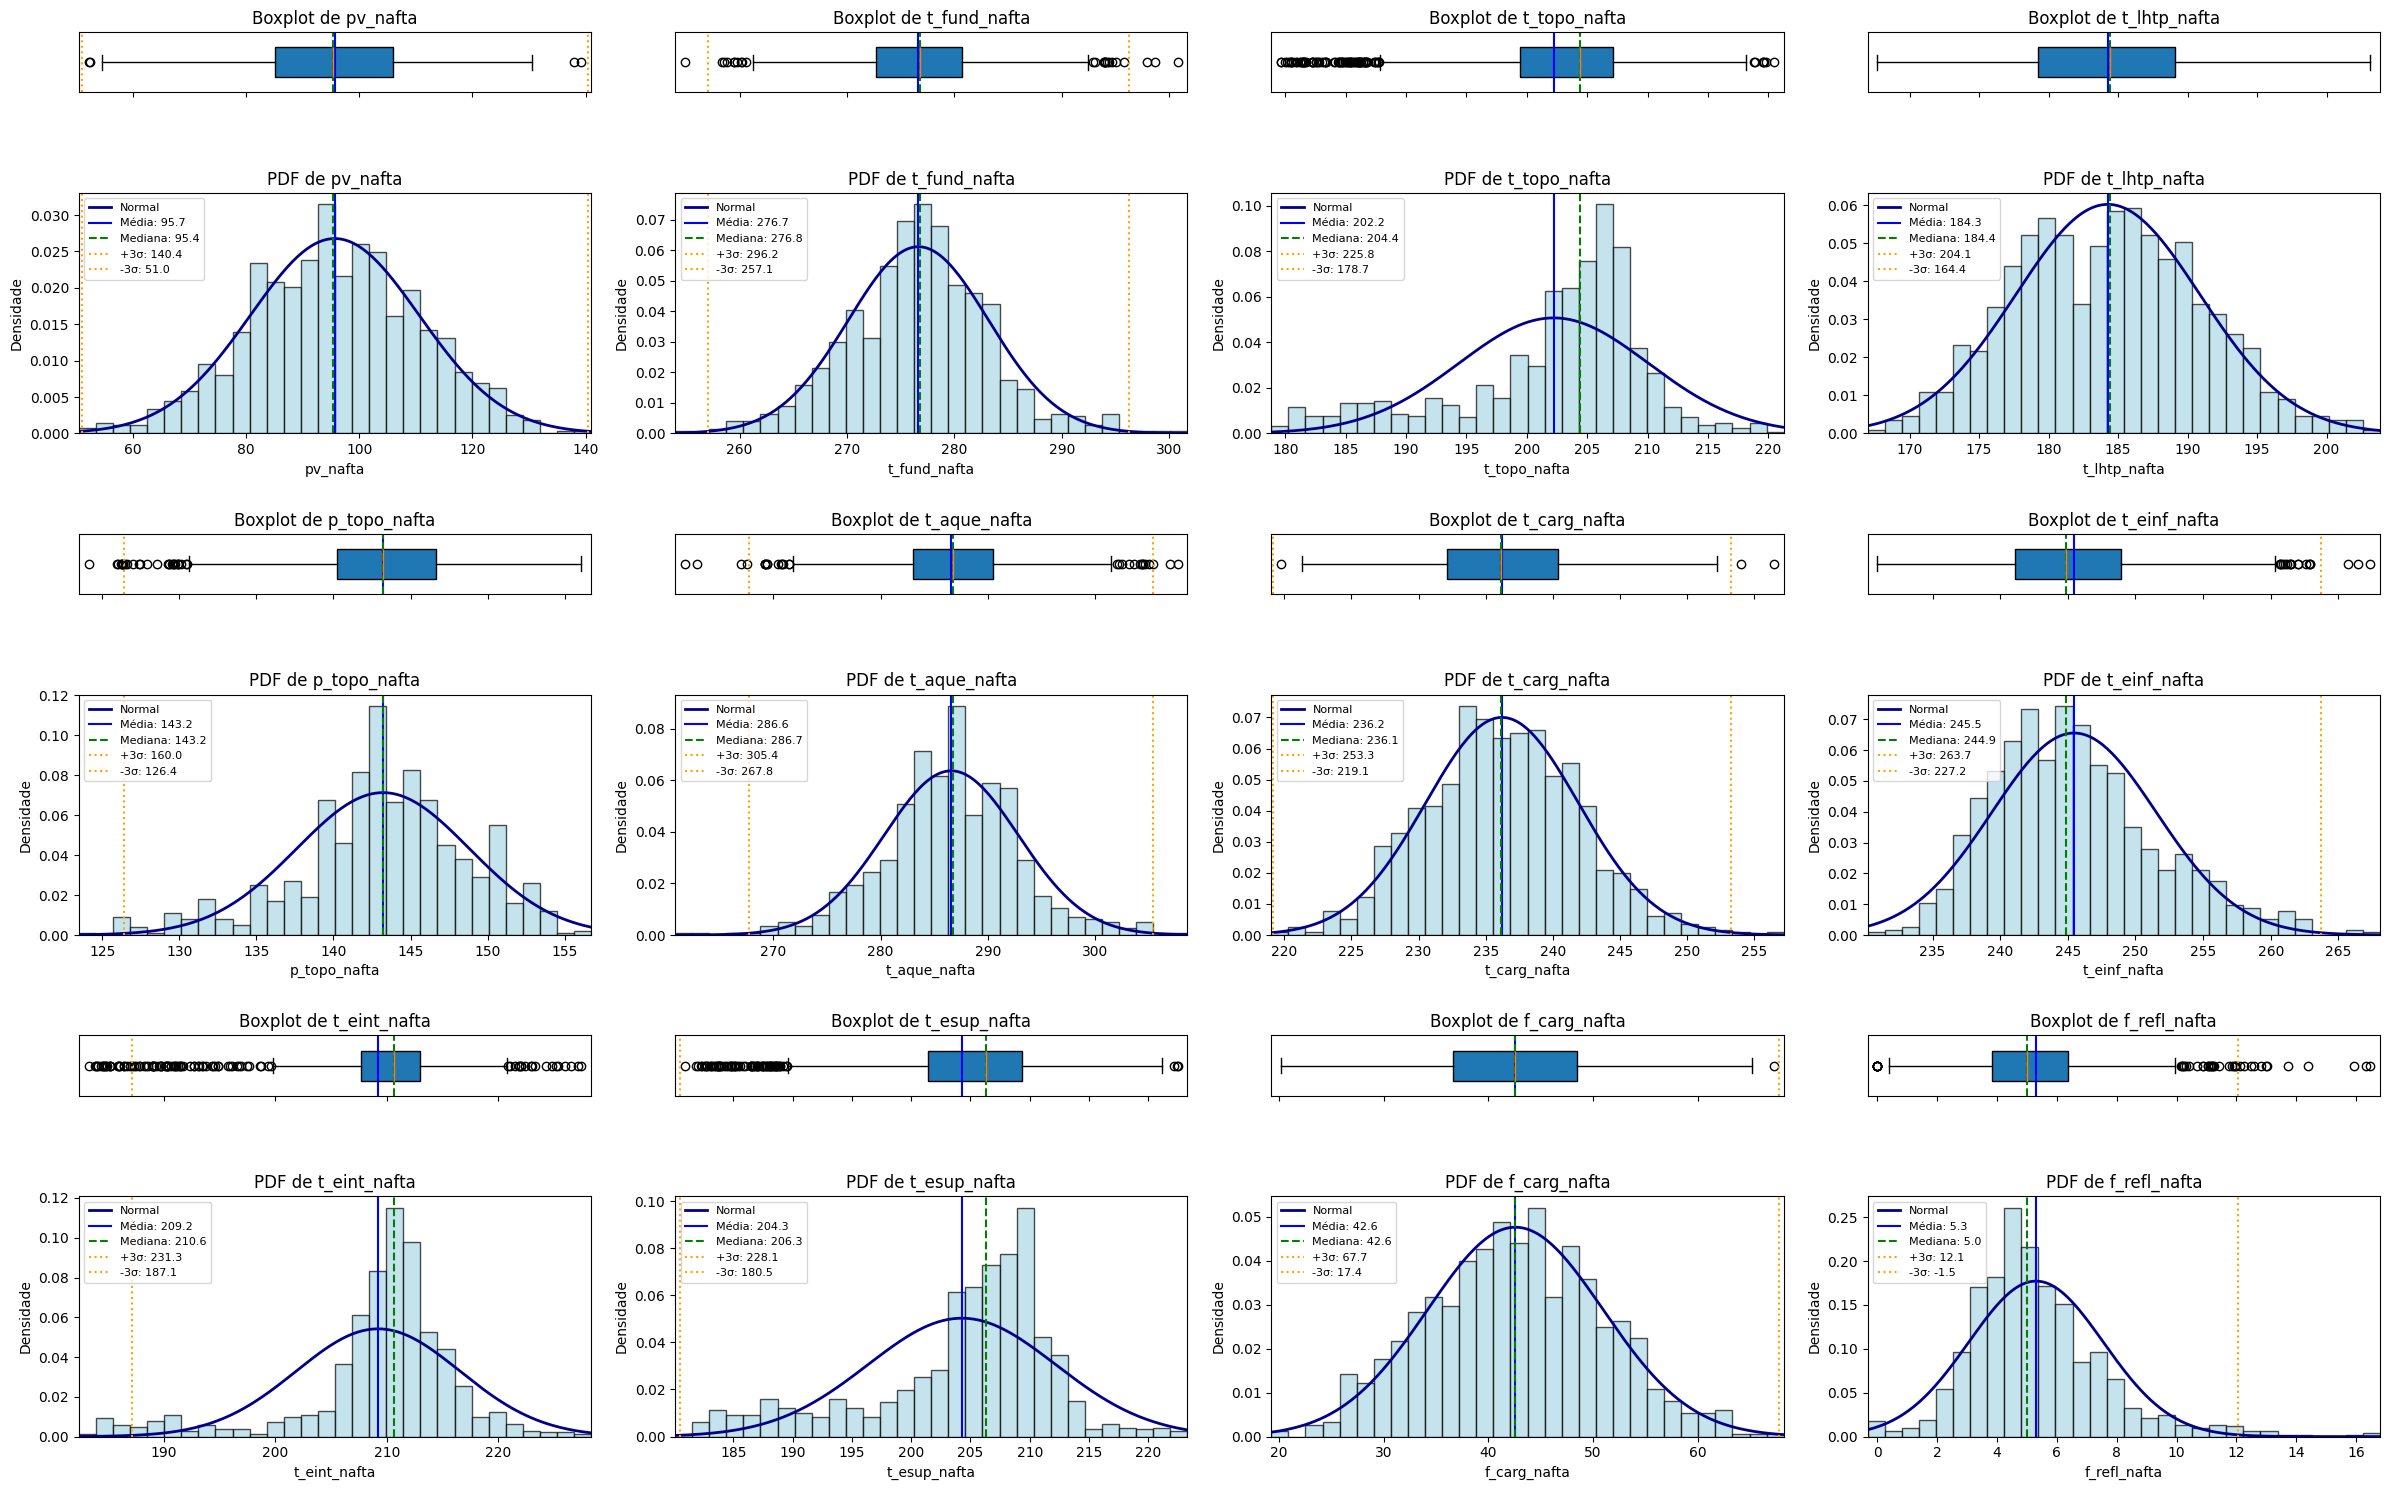

In [10]:
# estasticas descritivas básicas do dataset
print('Estatísticas descritivas:\n')
# Exibe as estatísticas descritivas transpostas com floats formatados para 2 casas decimais
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(df.describe().T)
fig = plot_boxplot_pdf(df, n_cols=4)
display(fig)

É possível observar que nas unidades de engenharia utilizadas não há um único padrão para todas as distribuições.<br>
Há algumas distribuições que aparentam a normalidade, mas que requerem avaliação específica para confirmação das hipóteses.

In [11]:
# Loop para aplicar a função teste_n em todas as colunas do DataFrame
print("Teste de normalidade para todas as variáveis:")
print("=" * 60)

normality_results = {}
for col in df.columns:
    print(f"Variável: '{col}'")
    _, p_valor = teste_n(df, col)
    normality_results[col] = "Normal" if p_valor > 0.05 else "Não normal"
    print("-" * 60)

# # Criar um DataFrame com os resultados para melhor visualização
# normality_df = pd.DataFrame.from_dict(normality_results, orient='index', columns=['Distribuição'])
# print("\nResumo dos testes de normalidade:")
# print(normality_df)

# Calcular a proporção de variáveis com distribuição normal
normal_count = sum(1 for status in normality_results.values() if status == "Normal")
print(f"\nProporção de variáveis com distribuição normal: {normal_count}/{len(df.columns)} ({normal_count/len(df.columns)*100:.1f}%)")

Teste de normalidade para todas as variáveis:
Variável: 'pv_nafta'
A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor: 0.93154
------------------------------------------------------------
Variável: 't_fund_nafta'
A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor: 0.08258
------------------------------------------------------------
Variável: 't_topo_nafta'
A amostra não parece vir de uma distribuição normal (rejeitamos a hipótese nula) p-valor: 0.00000
------------------------------------------------------------
Variável: 't_lhtp_nafta'
A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor: 0.12972
------------------------------------------------------------
Variável: 'p_topo_nafta'
A amostra não parece vir de uma distribuição normal (rejeitamos a hipótese nula) p-valor: 0.00004
------------------------------------------------------------
Variável: 't_aque_na

Nesse dataset 50% dos atributos apresentam distribuição consideradas normal.

### 3.3.4. Matriz de Correlação

A matriz de correlação mede a força e a direção de uma relação linear entre os atributos do dataset.<br>
Valores próximos a 1 indicam uma forte correlação positiva, -1 uma forte correlação negativa, e 0 ausência de correlação linear.

Para simplificar a visualização de correlação linear, o mapa de calor será realizado com o valor absoluto da correlação [0,1] ao invés de [-1, 1]


Para simplificar a visualização de correlação linear, o mapa de calor será realizado com o valor absoluto da correlação [0,1] ao invés de [-1, 1]



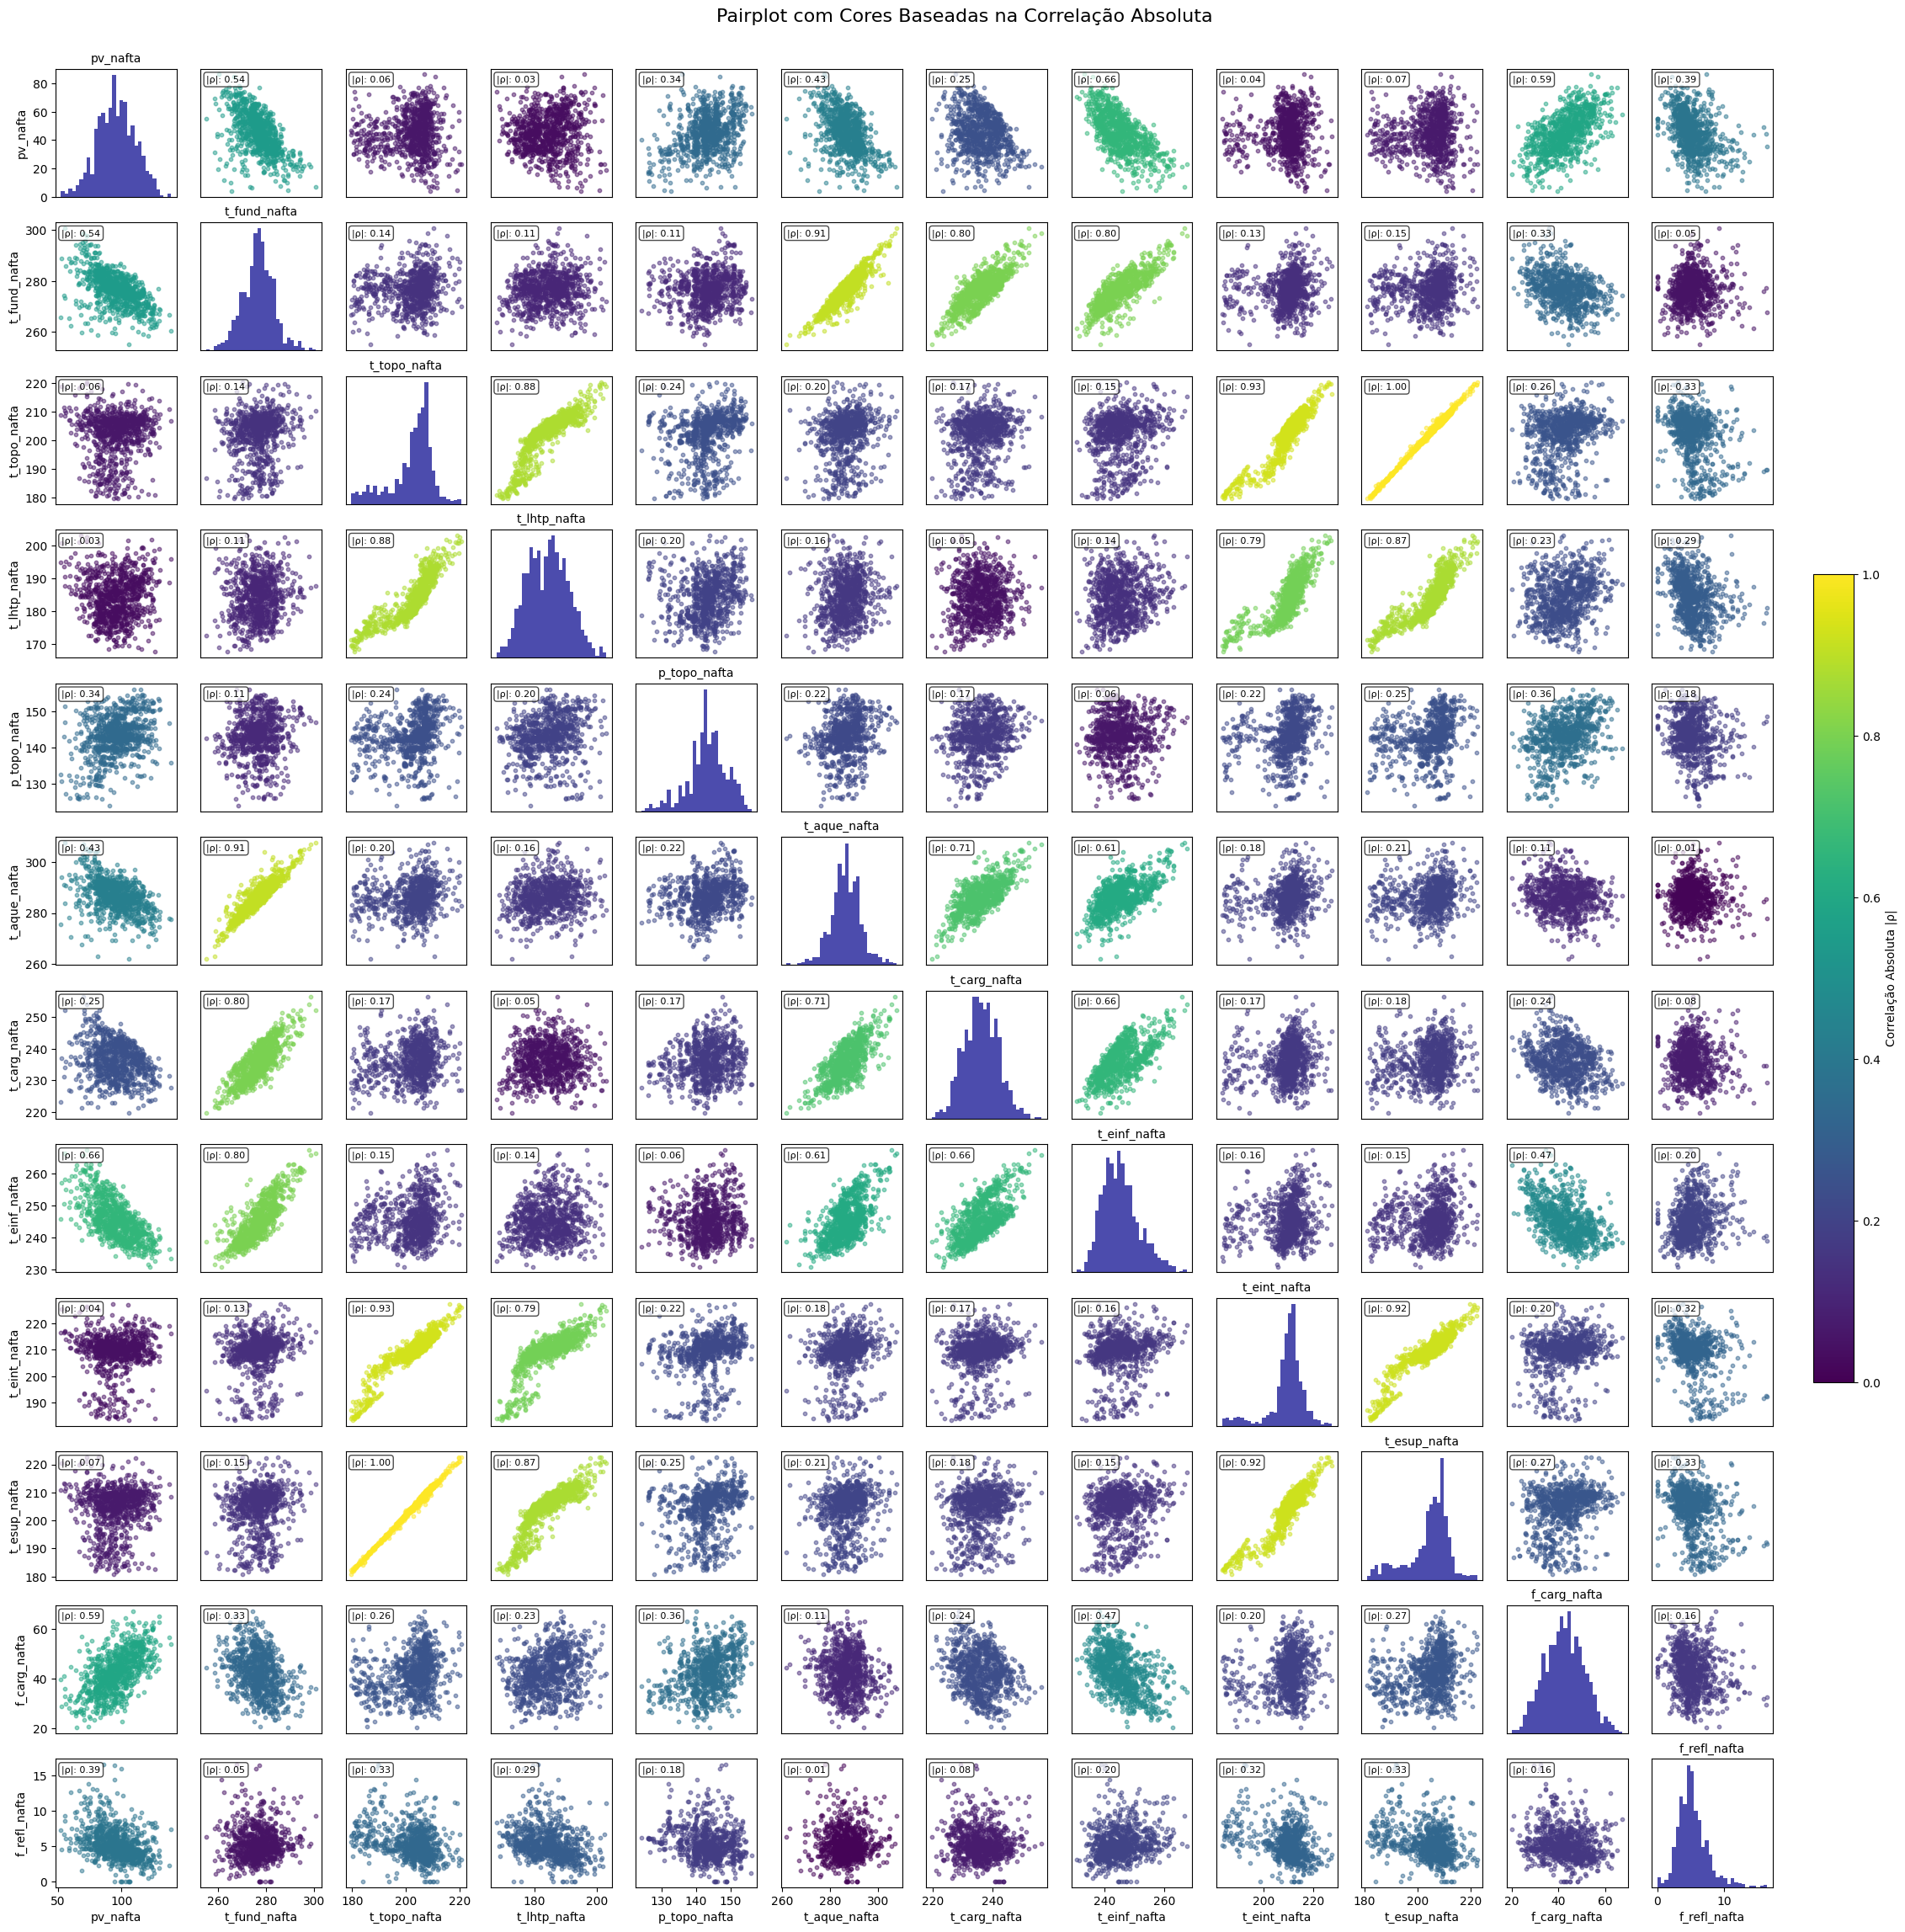

In [12]:
# Matriz de correlação
print("\nPara simplificar a visualização de correlação linear, o mapa de calor será realizado com o valor absoluto da correlação [0,1] ao invés de [-1, 1]\n")
# print(df.corr())
calcula_corr(df)
print("\n")
fig = pairplot_corr_hm(df, figsize=(24, 24), hist_bins=30, s=10, alpha=0.5)
display(fig)

É possível observar dentre as variáveis independentes que há algumas correlações significativas e que serão tratadas doravante com a utilização da técnica de VIF.

### 3.3.5. Análise de VIF

Análise de VIF (Variance Inflation Factor ou Fator de Inflação da Variância) é uma medida para quantificar o grau de multicolinearidade entre as variáveis independentes do dataset. A multicolinearidade ocorre quando duas ou mais variáveis independentes estão altamente correlacionadas, o que pode dificultar a estimativa dos coeficientes da regressão e afetar a interpretação dos resultados, principalmente para modelos lineares. Indica ainda que duas variável possam estar carregando o mesmo tipo de contribuição para a variância do processo, permitindo, dentro do domínio do conhecimento realizar supressões para redução de dimensionalidade.

Interpretação do VIF:
- VIF = 1: não há correlação entre a variável $i$ e as outras variáveis. A variância não está inflacionada.
- 1 < VIF < 5: a correlação é moderada, mas geralmente não é uma preocupação.
- VIF ≥ 5: indica uma alta correlação e pode ser motivo de preocupação; a variável pode estar contribuindo para a multicolinearidade.
- VIF ≥ 10: geralmente considerado um sinal forte de multicolinearidade, e pode ser necessário considerar a remoção da variável ou a aplicação de técnicas de regularização.

In [13]:
calcula_vif(df,target)


VIF das variáveis (ordem decrescente):

Variable  t_topo_nafta  t_esup_nafta  t_fund_nafta  t_aque_nafta  t_eint_nafta  t_lhtp_nafta  t_einf_nafta  t_carg_nafta  f_carg_nafta  f_refl_nafta  p_topo_nafta
VIF           228.7761      209.0824       16.9477        8.9510        7.8474        4.9770        4.6480        3.3451        1.9970        1.3726        1.3351


Processo iterativo de remoção de variáveis independentes até a obtenção de maior VIF < 10 (desejavelmente < 5).<br>
Nesse momento é importante analisar o VIF não apenas como um critério estatístico, mas também com o domínio do conhecimento.<br>

Dentro do domínio, as variáveis independentes **'t_topo_nafta'**, **'t_esup_nafta'**, **'t_eint_nafta'** e **'t_lhtp_nafta'** apresentam interdependência por representar parte do equilíbrio termodinâmico nessa seção da torre. Como também observado nas correlações, podemos aplicar redução de dimensionalidade do dataset pela supressão de alguma delas.

Nesse conjunto de variáveis observamos que as 4 variáveis estão entre as 6 maiores contribuições de VIF. O objetivo é realizar a menor supressão de regressores que carreguem informações semelhantes. Das 4 variáveis **'t_eint_nafta'** é a que carrega menor VIF, indicando ser a candidata a permanecer, pois ao suprimir uma das variáveis que encontram-se com VIF maior, provavelmente se enquadrará em VIF < 5.

Iniciando a exclusão da variável de maior VIF (**'t_topo_nafta**) já tivemos uma melhora significativa, no entanto ainda com VIF para as variáveis desse grupo superior a 10. Então foi excluída mais uma variável (**'t_esup_nafta'**) alcançando então VIF < 5 para as variáveis desse grupo.

In [14]:
# Remoção de atributos com alta correlação (multicolinearidade)
df1 = df.drop(columns=['t_topo_nafta','t_esup_nafta'])
calcula_vif(df1,target)


VIF das variáveis (ordem decrescente):

Variable  t_fund_nafta  t_aque_nafta  t_einf_nafta  t_carg_nafta  t_lhtp_nafta  t_eint_nafta  f_carg_nafta  f_refl_nafta  p_topo_nafta
VIF            16.8852        8.9172        4.6346        3.1999        2.9801        2.8978        1.9248        1.3674        1.3347


De forma análoga à seção anterior, o conjunto de **'t_fund_nafta'**, **'t_aque_nafta'**, **'t_carga_nafta'** e **'t_einf_nafta'** representam parte do equilíbrio termodinâmico na região inferior da torre, permitindo-nos realizar a redução de dimensionalidade como realizado anteriormente.

As candidatas naturais pelo critério estatístico seriam **'t_fund_nafta'** ou **'t_aque_nafta'**, no entanto a **'t_fund_nafta'** melhor caracteriza o que poderia ser um indicativo de preservação ou supressão de leves na nafta, pois já está saindo da torre para produção do produto final, entanto **'t_aque_nafta'** é um reciclo que não necessariamente indica o acabamento do produto, mas sim uma oportunidade para alteração do equilíbrio termodinâmica na torre, mas que está sendo contempladas pelas demais variáveis dessa mesma seção que serão preservdas.

In [15]:
# Remoção de atributos com alta correlação (multicolinearidade)
df2 = df1.drop(columns=['t_aque_nafta'])
calcula_vif(df2,target)


VIF das variáveis (ordem decrescente):

Variable  t_fund_nafta  t_einf_nafta  t_carg_nafta  t_lhtp_nafta  t_eint_nafta  f_carg_nafta  f_refl_nafta  p_topo_nafta
VIF             4.4608        3.9350        3.1915        2.9763        2.8878        1.8025        1.3584        1.3046


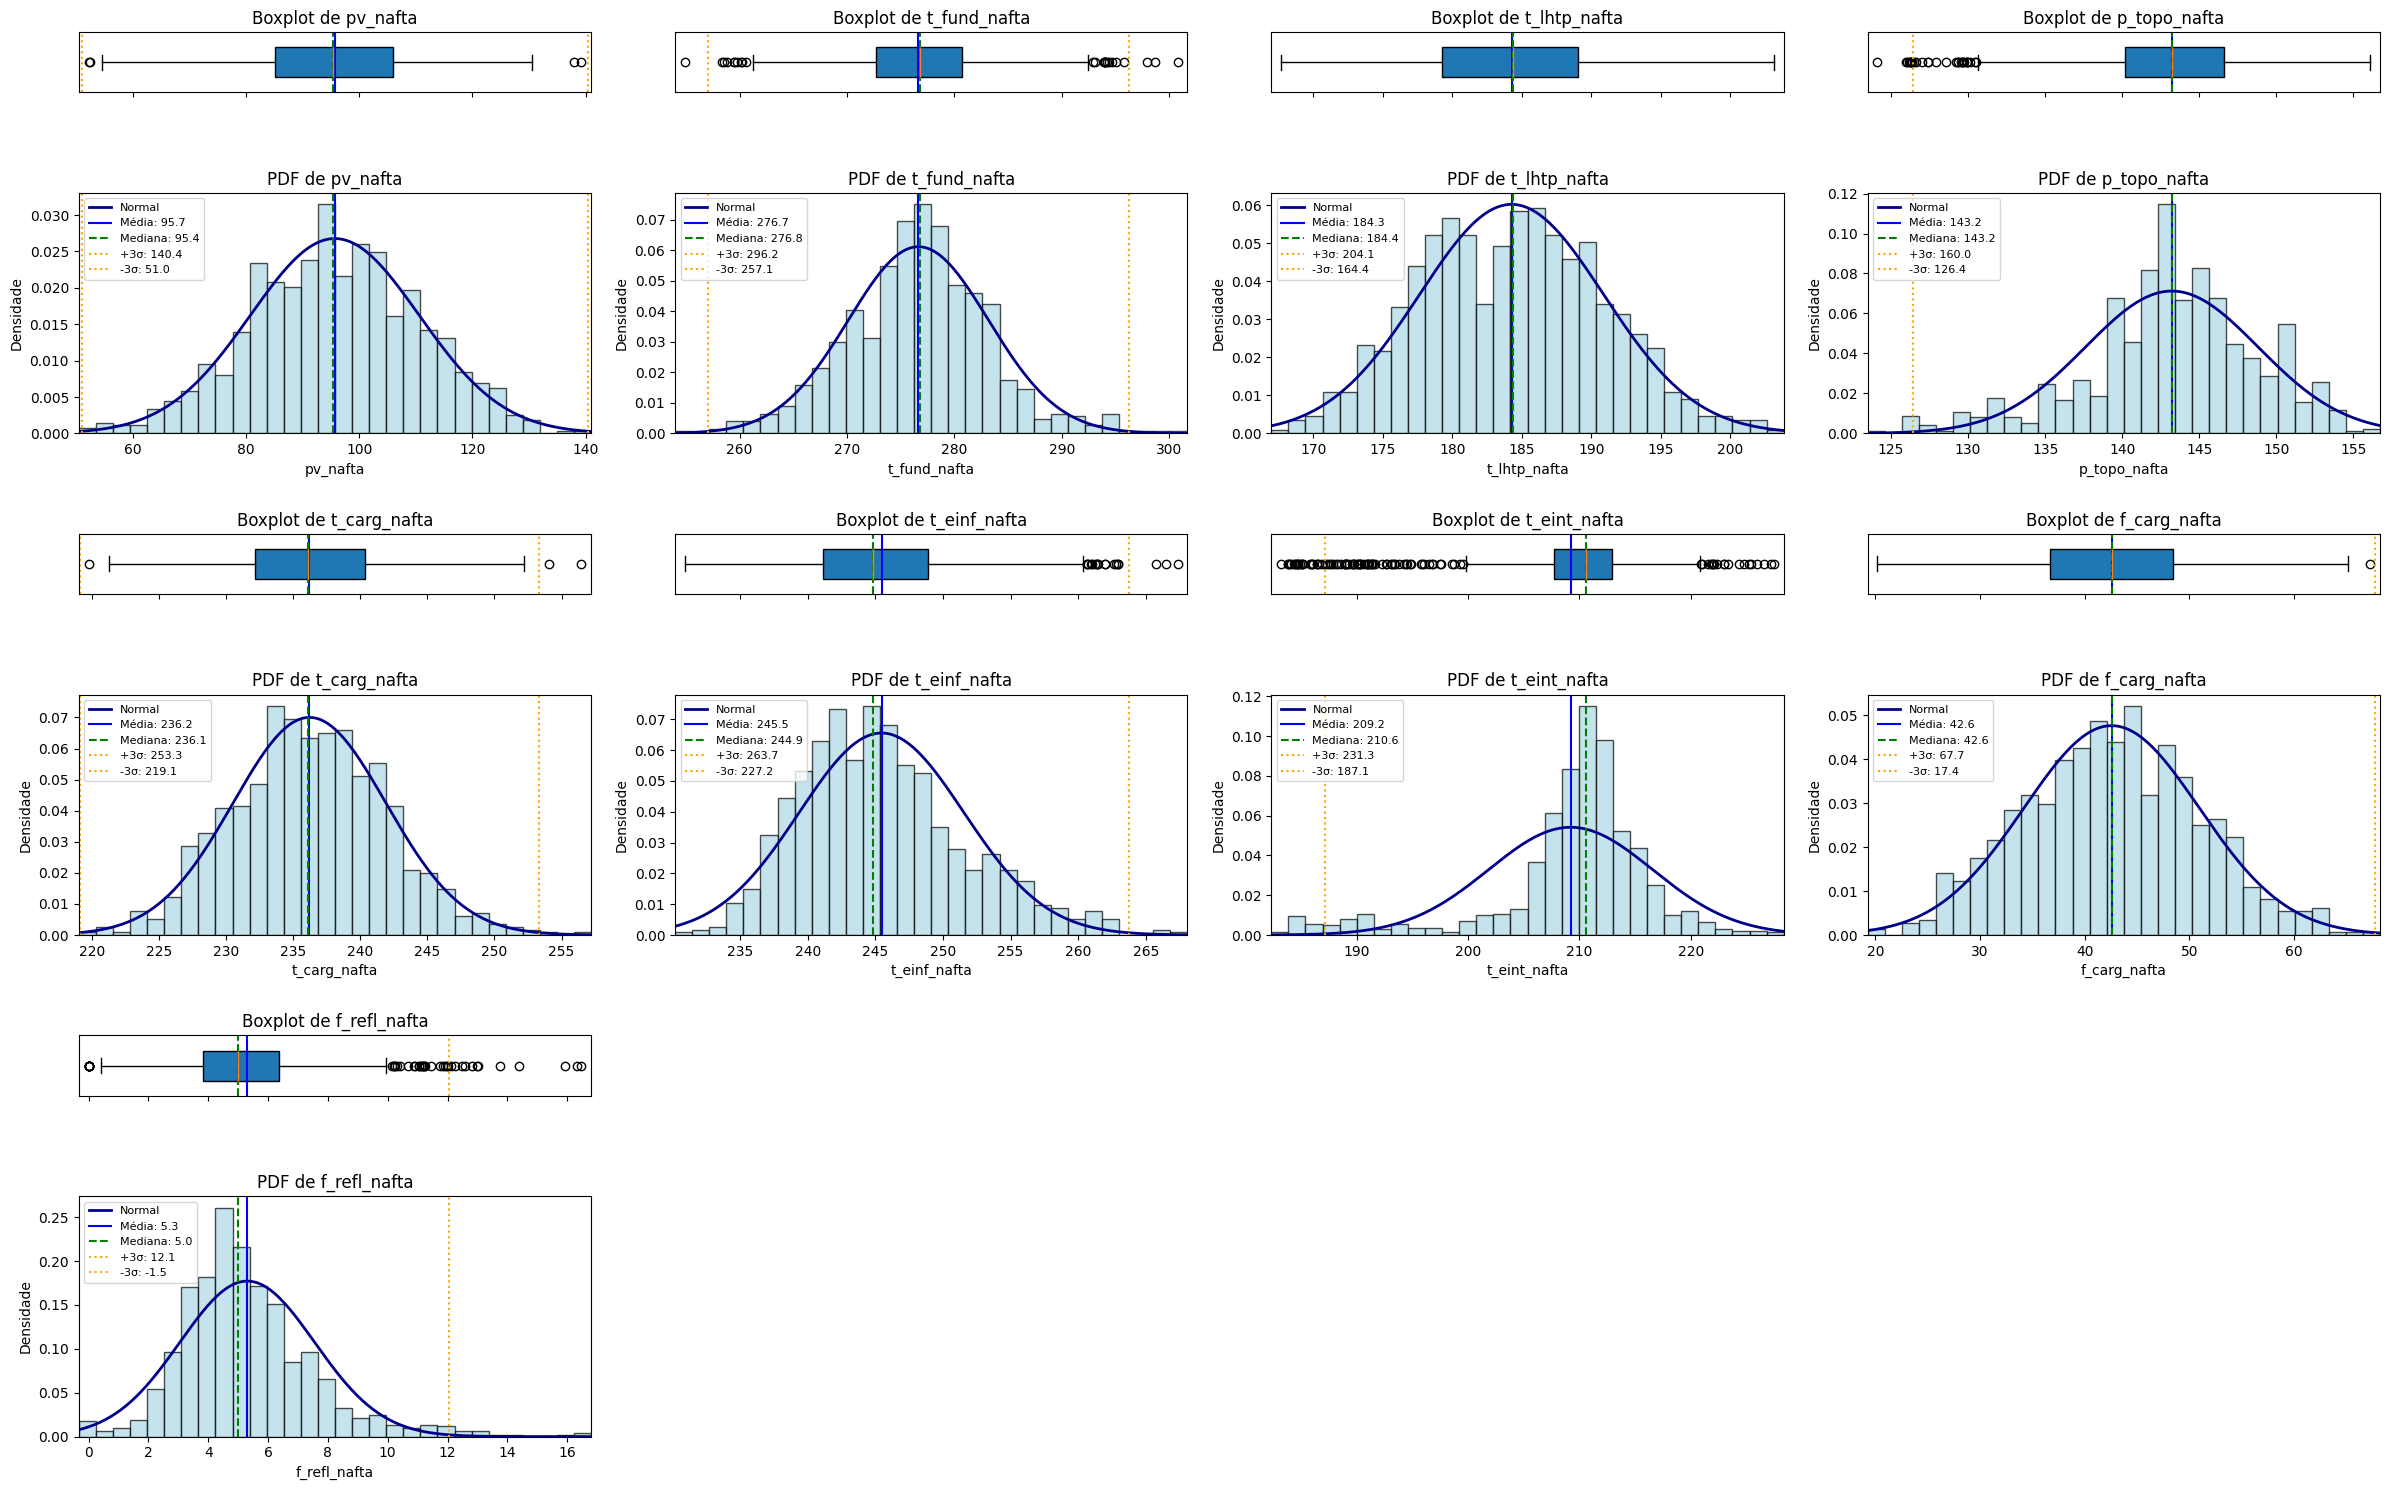

In [16]:
# Resumo das distribuições dos atributos remanescentes

fig = plot_boxplot_pdf(df2)
display(fig)

Com isso, excluindo **'t_aque_nafta'** enquadramos o critérios da VIF e preservando melhor as informações do processo físico-químico.

### 3.3.6. Criação de novas características



Razão de refluxo: uma variável derivada, definida como a relação entre a vazão de refluxo de topo **'f_refl_nafta'** e a vazão de carga da fracionadora **'f_carg_nafta'** (**'f_refl_nafta'**/**'f_carg_nafta'**). Esta variável representa um parâmetros operacionais que pode ser críticos em fracionadoras, pois determina a eficiência da separação dos componentes.

Eficiência da separação: valores mais altos de razão de refluxo proporcionam maior contato entre as fases líquida e vapor em cada estágio do fracionamento, resultando em melhor separação dos componentes com diferentes volatilidades.

Controle da composição do produto: ao aumentar a razão de refluxo, mais componentes leves são retidos e retornam à fracionadora em vez de saírem no produto de topo, esperando-se uma elevação da pressão de vapor da nafta que sai pelo fundo da fracionadora.

Estabilidade operacional: uma razão de refluxo adequada ajuda a manter condições operacionais estáveis, reduzindo flutuações na qualidade do produto.

Perfil térmico da coluna: influencia diretamente o gradiente de temperatura ao longo da fracionadora, afetando a distribuição dos componentes em cada estágio.

Implicações: na prática, existe um trade-off importante no ajuste da razão de refluxo:

- Razão de refluxo baixa: menor consumo energético e maior capacidade de processamento, porém com qualidade de separação potencialmente comprometida.

- Razão de refluxo alta: melhor separação e controle mais preciso da pressão de vapor do produto, porém com maior consumo energético e menor capacidade de processamento.

Para a predição da pressão de vapor da nafta, a razão de refluxo representa uma variável derivada de alto valor preditivo, pois sintetiza em um único parâmetro a interação entre duas variáveis operacionais críticas que afetam diretamente o equilíbrio termodinâmico e a composição do produto final.

A inclusão desta variável no modelo preditivo provavelmente aumentará seu poder explicativo, capturando um mecanismo de controle operacional que impacta a propriedade alvo que estamos tentando prever.

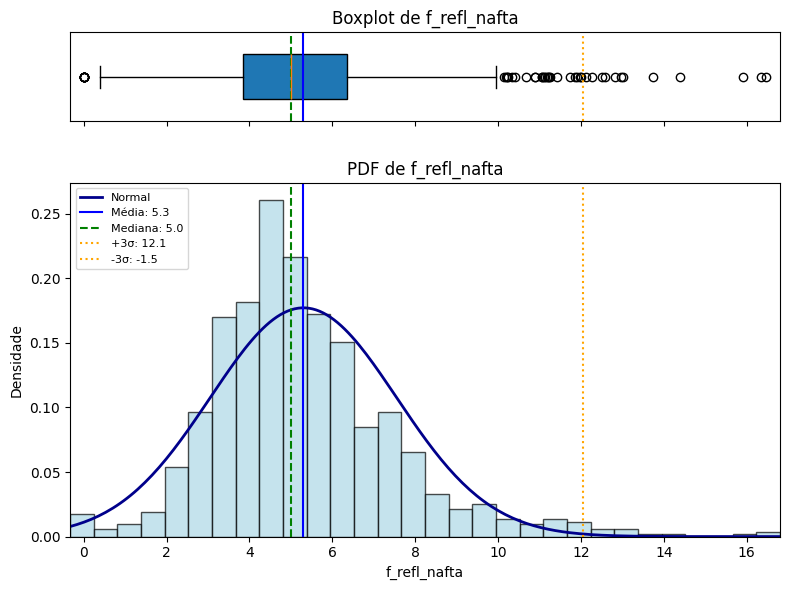

In [17]:
df2['r_refl_nafta'] = df2['f_refl_nafta'] / df2['f_carg_nafta']
fig = plot_boxplot_pdf_indiv(df2, 'f_refl_nafta')
display(fig)

O novo atributo criado apresenta distribuição assimétrica à direita, com uma cauda da distribuição se estendendo nesse sentido, indicando a presença de valores mais altos menos frequentes. Esse comportamento é derivado da variável **'f_refl_nafta'** que deu origem a essa nova criação, conforme já apresentado anteriormente.

Vamos avaliar como ficaram as correlações e a VIF após essa nova vaiável.

In [18]:
calcula_vif(df2,target)
calcula_corr(df2)


VIF das variáveis (ordem decrescente):

Variable  r_refl_nafta  f_refl_nafta  f_carg_nafta  t_fund_nafta  t_einf_nafta  t_carg_nafta  t_lhtp_nafta  t_eint_nafta  p_topo_nafta
VIF            24.1154       18.2250        6.2141        4.4625        3.9462        3.1929        3.1915        3.0341        1.3351


É possível observar uma elevada correlação, conforme esperado, entre **'f_refl_nafta'** e a nova **'r_refl_nafta'**. Em função da relevância dessa nova variável, conforme explicado anteriormente e até mesmo uma maior correlação com a variável alvo, vamos suprimir a **'f_refl_nafta'** para reduzir a VIF (reduzir a mulcolinearidade).

In [19]:
df3 = df2.drop(columns=['f_refl_nafta'])
calcula_vif(df3,target)


VIF das variáveis (ordem decrescente):

Variable  t_fund_nafta  t_einf_nafta  t_carg_nafta  t_eint_nafta  t_lhtp_nafta  f_carg_nafta  r_refl_nafta  p_topo_nafta
VIF             4.4596        3.8598        3.1878        2.9373        2.9223        1.9199        1.7974        1.2920


Como a VIF ficou novamente abaixo de 5 vamos parar a remoção de variáveis nessa etapa.

# 4. Separação e divisão do dataset entre features (X) e target (y)

Iniciamos aqui o uso das definições paramétricas realizadas na seção 2.3 para o problema de aprendizado de máquina. Definimos uma semente (SEED) para garantir a reprodutibilidade. Os demais parâmetros estão relacionados aos critérios de separação dos dados entre treino e teste (SPLIT), a quantidade de 'folds" na validação cruzada (CV_FOLDS) e por último, e não menos importante, a definição da métrica de avaliação.

A escolha pelo RMSE é muito mais pela intuição que essa métrica trás em relação ao erro médio, já que representa o erro absoluto médio na escala de engenharia do target.

In [20]:
X = df3.drop(target, axis=1)
y = df3[target].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT, random_state=SEED, stratify=y if PROBLEM_TYPE=="classificacao" else None
)
print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("Tipo:", PROBLEM_TYPE)
print("Target:", target)
print("Nº features:", X.shape[1])

Treino: (588, 8) | Teste: (318, 8)
Tipo: regressao
Target: pv_nafta
Nº features: 8


Separação prévia entre dados de treino e de teste para evitar vazamento de dados. Os dados de teste são considerados intocados.

Em tempo, sobraram 8 variáveis dependentes para utilização no modelo.

# 5. Seleção de algorítmos e definição da Baseline

## 5.1. Algorítmos

Selecionados previamente no início do notebook

### 5.1.1. Algorítmos de regressão

Algoritmos Lineares: Assumem relação linear entre features e target, são interpretáveis, mas limitados em capturar relações complexas.
  - ElasticNet, SVR (kernel linear). O uso do modelo Linear OLS, Ridge e Lasso foram preteridos, pois um alpha tendendo a zero (sem regulariozação) seria quase a representação do OLS. E o l1_ratio = 0 seria o Ridge e l1_ratio = 1 seria o Lasso.

Algoritmos Baseados em Distância: Fazem previsões com base na similaridade/distância entre pontos de dados, não fazem suposições sobre a distribuição.
  - KNN, SVR (kernels não lineares)

Algoritmos Baseados em Árvores:
   - Árvore Única: Divide o espaço de features recursivamente, altamente interpretável mas propensa a overfitting.
     - DecisionTree
   - Ensembles - Bagging: Reduz a variância combinando múltiplos modelos treinados em diferentes subconjuntos dos dados.
     - Random Forest, Bagging, Extra Trees
   - Ensembles - Boosting: Reduz o viés construindo modelos sequencialmente, cada um focando nos erros dos anteriores.
     - Ada Boost, Gradient Boost, XG Boost, Light GBM, Cat Boost

### 5.1.2. Métodos de padronização (Scalers)

Considerando a estratégia de escolha dos algorítmos de regressão e sabendo que algoritmos baseados em árvores geralmente não são sensíveis à escala das features (talvez influenciados por grande assimetria), devemos nos concentrar na escolha dos scalers para os algoritmos lineares, baseados em distância e os baseados em redes neurais. E ainda, como é sabido que outliers foram tratados na etapa de pre-processamento, Robust Scaler pode ser preterido.

Desta forma, vamos selecionar StandardScaler, MinMaxScaler e para avaliar eventuais impactos de assimetria na distribuição de algumas features, vamos considerar ainda uma PowerTransformer com o método de 'Yeo-Johnson', dado que esse método é mais robusto que o 'Box-Cox' por contemplar tratamento de valores negativos. Não vamos seguir com dados não padronizados em função de alguns algoritmos não lidarem bem com ele, como os algoritmos baseados em distâncias (por exemplo).

### 5.1.3. Métricas calculadas

Em relação às métricas a escolha foi baseada na representatividade da explicação da variabilidade (R²) pelo modelo, na dimensão do erro na escala de engenharia da medida do target (RMSE), o erro quadrático médio (MSE), aonde valores mais extremos de erro tem maior penalização e também o erro absoluto (MAE).


In [21]:
# Carregando dos algoritmos de regressão
filename = 'algo_configs.json'
if os.path.getsize(filename) == 0:
    raise ValueError(f"O arquivo '{filename}' está vazio. Gere ou preencha o arquivo antes de carregar.")
with open(filename, 'r', encoding='utf-8') as f:
    algo_configs = json.load(f)

# Métodos de padronização
scalers = SCALERS_CONFIGS

# Definição das métricas de avaliação
scoring = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

# Sumário das configurações carregadas
print("Algorítmos considerados:\n")
for i, (scaler_name,scaler) in enumerate(scalers):
    print(f"Scaler[{i}]: {scaler_name}")

print('')

for i, (key, cfg) in enumerate(algo_configs.items()):
    alias = cfg.get('alias')
    model_class = cfg.get('model_class')
    module_name = cfg.get('module')
    default_params = cfg.get('default_params')
    search_space = cfg.get('search_space')
    print(f"Algoritmos[{i}]: {alias}")

print(f'\nA métrica de otimização selecionada é: {METRIC_TO_OPT}\n')

Algorítmos considerados:

Scaler[0]: Minmax
Scaler[1]: Standard
Scaler[2]: YeoJohn

Algoritmos[0]: ElasticNet
Algoritmos[1]: SVR
Algoritmos[2]: KNN
Algoritmos[3]: DecisionTree
Algoritmos[4]: RandomForest
Algoritmos[5]: AdaBoost
Algoritmos[6]: GradientBoost
Algoritmos[7]: Bagging
Algoritmos[8]: ExtraTrees
Algoritmos[9]: LightGBM
Algoritmos[10]: XGBoost
Algoritmos[11]: CatBoost

A métrica de otimização selecionada é: rmse



## 5.2. Baseline

Como Baseline a escolha foi pelo algoritmo Elastic Net (linear) em função da sua simplicidade.

In [22]:
# Modelo baseline
baseline = algo_configs[list(algo_configs.keys())[0]]
baseline_model = baseline['alias']
print(f"\nBaseline - Modelo: {baseline_model}")


Baseline - Modelo: ElasticNet


# 6. Treinamento dos modelos com otimização de hiperparâmetros

Essa etapa representa a parte central do processo de busca dos melhores modelos. Nessa etapa é aonde definimos a estratégia de otimização dos hiperparâmetros, bem como armazenamos todas as informações do treinamento.

A motivação da escolha o algorítmo Bayes Search pelo fato de ser como um explorador que aprende a cada tentativa. Diferentemente do Grid Search (que testa todas as combinações possíveis) e do Random Search (que testa combinações aleatórias). Ele se destaca por ser mais rápido e eficiente, pois usa o que aprendeu em tentativas anteriores para decidir quais configurações testar na próxima tentativa. Isso economiza muito tempo e recursos computacionais, especialmente quando treinar cada modelo leva muito tempo. Em vez de testar às cegas, o Bayes Search concentra seus esforços em áreas promissoras, conseguindo encontrar as melhores configurações com menos tentativas, como um caçador que sabe interpretar pistas para chegar ao objetivo mais rapidamente.

Note que o código está comentado justamente para poupar o extenso tempo requerido.

Na célula subsequente é possível restaurar um arquivo **JOBLIB** para sequência das avaliações.

In [23]:
# # --- Célula de Otimização de Hiperparâmetros com BayesSearchCV ---
# N_ITER = 50  # Número de iterações da busca. Aumentar para uma busca mais exaustiva.

# results = {}
# cv_results = {}
# test_results = {}
# opt_res = {}
# opt_res2 = {}

# # Criar o objeto de cross-validation explicitamente
# cv_splitter = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)

# # Criar um callback DeltaYStopper com delta para a métrica escolhida
# delta_metric = 0.001 if METRIC_TO_OPT in ['r2'] else 0.5

# for scaler_name, scaler in scalers:
#     for i, (algo_name, config) in enumerate(algo_configs.items()):
#         print(f"Executando HPO para: {config.get('alias')} - {scaler_name}")
#         start_time = time.time()

#         model_class = config["model_class"]
#         module_name = config["module"]
#         model_cls = getattr(importlib.import_module(module_name), model_class)
#         model = model_cls(**config["default_params"])

#         pipe = Pipeline([
#             ("scaler", scaler),
#             ("model", model)
#         ])

#         # Reconstruir search_space com o prefixo 'model__' para uso com Pipeline
#         search_space = {f"model__{k}": _deserialize_space(v) for k, v in config.get("search_space", {}).items()}

#         opt = BayesSearchCV(
#             estimator=pipe,
#             search_spaces=search_space,
#             n_iter=N_ITER,
#             cv=cv_splitter,
#             scoring=get_regression_metric(METRIC_TO_OPT),
#             random_state=SEED,
#             n_jobs=-1,
#             return_train_score=True,
#             verbose=0
#         )

#         opt.fit(X_train, y_train, callback=[DeltaYStopper(delta=delta_metric, n_best=10)])

#         end_time = time.time()
#         elapsed = end_time - start_time
#         print(f" - Tempo estimado para {config.get('alias')} - {scaler_name}: {elapsed:.2f} segundos")

#         best_model = opt.best_estimator_
#         best_idx = opt.best_index_

#         # Histórico completo da otimização bayesiana para cada (algoritmo, scaler)
#         opt_res[algo_name, scaler_name] = {
#             "optimizer_result": opt.optimizer_results_[0],
#             "elapsed_time": elapsed
#         }

#         y_pred_train = best_model.predict(X_train)

#         # Resultados finais de cada combinação de algoritmo e scaler:
#         # Melhores hiperparâmetros, métricas (treino, teste, CV) e
#         # os scores dos folds apenas para o melhor modelo de cada busca.
#         results[algo_name,scaler_name] = {
#             "params": opt.best_params_,
#             "scores_dev": compute_metrics(y_train, y_pred_train)
#         }
#         # Armazena as métricas de cada fold do treino do cross-validation apenas para o melhor modelo
#         results[algo_name, scaler_name]["cv_scores"] = []
#         fold_metrics = {}
#         for fold in range(CV_FOLDS):
#             fold_metrics[f"fold_{fold}_train"] = opt.cv_results_[f'split{fold}_train_score'][best_idx]
#             fold_metrics[f"fold_{fold}_val"] = opt.cv_results_[f'split{fold}_test_score'][best_idx]
#         results[algo_name, scaler_name]["cv_scores"].append(fold_metrics)

# # Salvar variáveis para execução sem necessidade de novo treinamento
# # Lista de variáveis requeridas para a sequencia do código
# vars_to_save = [
#     'scalers', 'algo_configs', 'results', 'opt_res', 'N_ITER'
# ]

# # Dicionário para armazenar as variáveis
# vars_dict = {}

# for var in vars_to_save:
#     if var in globals():
#         vars_dict[var] = globals()[var]

# # Salvar em arquivo
# joblib.dump(vars_dict, 'training_checkpoint.joblib')
# print("Variáveis salvas em 'training_checkpoint.joblib'")

O treinamento durou 12 min em máquina dedicada com GPU.

Carregamento dos dados de testes.

In [24]:
# Para uso no COLAB, descomentar as linhas abaixo para baixar o arquivo
url_joblib = "https://raw.githubusercontent.com/fdamata/pucrj-machinelearning-mvp-ml/refs/heads/main/training_checkpoint.joblib"
# Executa o comando wget para baixar o arquivo
!wget {url_joblib} -O training_checkpoint.joblib

# Carregar variáveis salvas do arquivo 'training_checkpoint.joblib'
checkpoint = joblib.load('training_checkpoint.joblib')

# Exemplo de acesso às variáveis carregadas:
scalers = checkpoint['scalers']
algo_configs = checkpoint['algo_configs']
results = checkpoint['results']
opt_res = checkpoint['opt_res']
N_ITER = checkpoint['N_ITER']

# print("Variáveis carregadas de 'training_checkpoint.joblib':", list(checkpoint.keys()))

--2025-09-24 13:10:54--  https://raw.githubusercontent.com/fdamata/pucrj-machinelearning-mvp-ml/refs/heads/main/training_checkpoint.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3389198 (3.2M) [application/octet-stream]
Saving to: ‘training_checkpoint.joblib’

training_checkpoint 100%[===================>]   3.23M  --.-KB/s    in 0.01s   

2025-09-24 13:10:55 (231 MB/s) - ‘training_checkpoint.joblib’ saved [3389198/3389198]



## 6.1. Desempenho computacional do treinamento dos modelos

In [25]:
print(f"{'Algoritmo':<25} {'Scaler':<10} {'Iterações':<10} {'Early Stop?':<12} {'Tempo (s)':<10}")
print("-" * 75)
for (algo, scaler), res in opt_res.items():
    # Recupera o alias do algoritmo a partir do dicionário de configuração
    alias = algo_configs[algo]['alias'] if algo in algo_configs else algo
    n_iter = len(res['optimizer_result'].x_iters)
    elapsed = res['elapsed_time']
    early_stop = n_iter < N_ITER
    print(f"{alias:<25} {scaler:<10} {n_iter:<10} {'Sim' if early_stop else 'Não':<12} {elapsed:<10.2f}")

total_elapsed = sum(res['elapsed_time'] for res in opt_res.values())
print("-" * 75)
print(f"{'Tempo total (s):':<61}{total_elapsed:<10.2f}")

Algoritmo                 Scaler     Iterações  Early Stop?  Tempo (s) 
---------------------------------------------------------------------------
ElasticNet                Minmax     15         Sim          18.76     
SVR                       Minmax     18         Sim          11.26     
KNN                       Minmax     10         Sim          1.95      
DecisionTree              Minmax     16         Sim          6.53      
RandomForest              Minmax     10         Sim          9.28      
AdaBoost                  Minmax     19         Sim          18.41     
GradientBoost             Minmax     19         Sim          23.79     
Bagging                   Minmax     13         Sim          8.93      
ExtraTrees                Minmax     13         Sim          7.87      
LightGBM                  Minmax     21         Sim          63.71     
XGBoost                   Minmax     16         Sim          16.80     
CatBoost                  Minmax     17         Sim         

Importante observar que todos algorítmos se benecifiaram da atuação da estratégia de parada prematura do treinamento (early stop) em função de atingimento do critério de evolução da métrica (RMSE de 0,5 unidades de engenharia para 10 iterações).

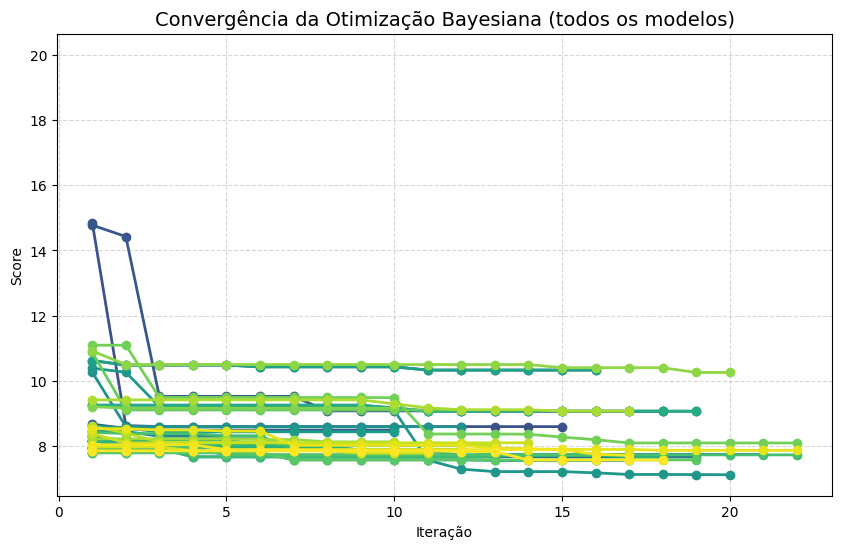

In [26]:
# Juntar todos os resultados de otimização em uma lista
optimizer_results = [res['optimizer_result'] for res in opt_res.values()]

# Calcular os limites globais do eixo y
all_func_vals = []
for res in optimizer_results:
	all_func_vals.extend(res.func_vals)
ymin = min(all_func_vals)
ymax = 20 # max(all_func_vals)
margin = 0.05 * (ymax - ymin) if ymax > ymin else 0.1
ymin_plot = ymin - margin
ymax_plot = ymax + margin

# Plotar todas as curvas de convergência em um único gráfico
fig, ax = plt.subplots(figsize=(10, 6))
plot_convergence(*optimizer_results, ax=ax,)
ax.set_ylim(ymin_plot, ymax_plot)
ax.set_title('Convergência da Otimização Bayesiana (todos os modelos)', fontsize=14)
ax.set_xlabel('Iteração')
ax.set_ylabel('Score')
ax.grid(True, linestyle='--', alpha=0.5)
# plt.show()
display(fig)

O número de iterações igual a 50 parece ter sido uma boa escolha dada a estagnação da métrica durante a validação cruzada (treinamento) antes mesmo de chegar a 25 iterações devido ao early stop.

## 6.2. Desempenho das métricas da validação cruzada (treino) dos modelos


Melhor modelo (baseado na mediana do CV): SVR com scaler Standard | Mediana rmse = 7.3535

Ordem  Algoritmo                 Scaler     CV Mediana±DP    Métrica (↓ melhor)
-------------------------------------------------------------------------------------
1      SVR                       Standard   7.3535 ± 0.6516  rmse      
2      CatBoost                  Standard   7.6125 ± 0.8214  rmse      
3      CatBoost                  YeoJohn    7.6861 ± 0.8332  rmse      
4      XGBoost                   Minmax     7.7003 ± 0.7290  rmse      
5      XGBoost                   Standard   7.7003 ± 0.7290  rmse      
6      CatBoost                  Minmax     7.7664 ± 0.8648  rmse      
7      ExtraTrees                Minmax     7.7857 ± 0.8316  rmse      
8      ExtraTrees                Standard   7.7857 ± 0.8316  rmse      
9      GradientBoost             Minmax     7.8022 ± 0.5290  rmse      
10     GradientBoost             Standard   7.8155 ± 0.6980  rmse      
11     LightGBM       

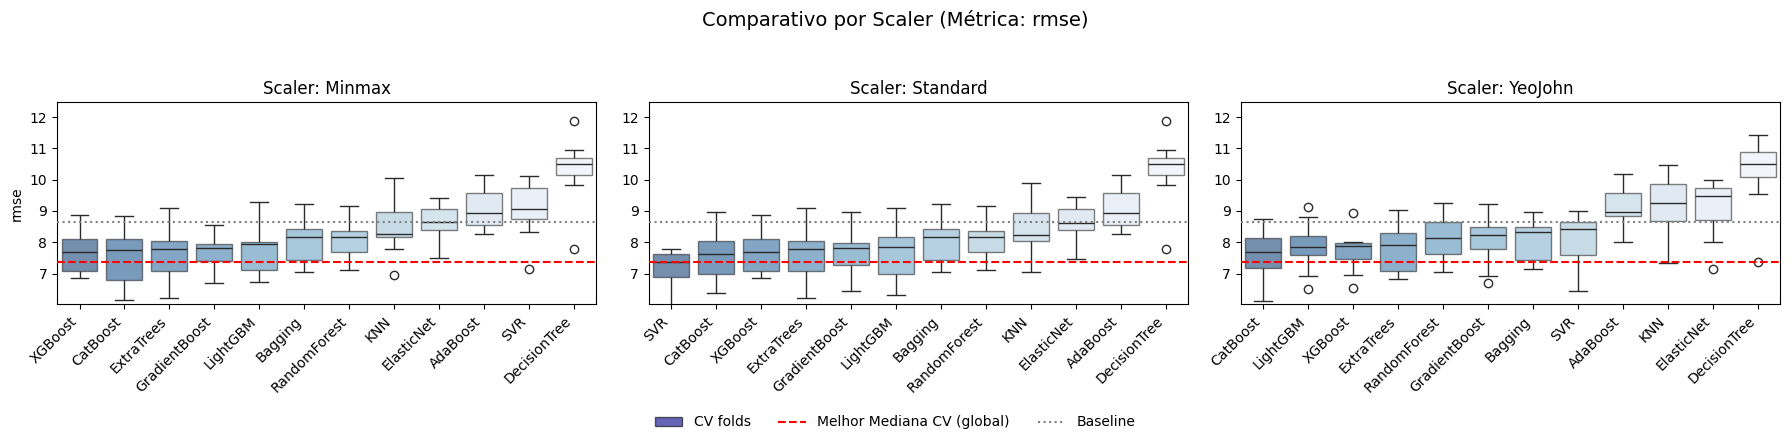

In [27]:
# Preparar dados para boxplot
data = []
ascending = METRIC_TO_OPT.lower() in MINIMIZE_METRICS

for (algo, scaler), result in results.items():
    # Adiciona os scores de validação de todos os folds
    for fold_name in result['cv_scores'][0]:
        if fold_name.startswith('fold_') and fold_name.endswith('_val'):
            score = result['cv_scores'][0][fold_name]
            # Para métricas de minimização (sklearn retorna negativo), usa o valor absoluto
            if ascending:
                score = abs(score)
            data.append({'Algoritmo': algo_configs[algo]['alias'], 'Scaler': scaler, 'Score': score, 'Type': 'CV'})

df_box = pd.DataFrame(data)

# --- LÓGICA PARA ENCONTRAR O MELHOR MODELO ---
if not df_box.empty:
    # 1. Calcular a mediana dos scores de CV para cada combinação
    model_performance = df_box.groupby(['Algoritmo', 'Scaler'])['Score'].median()

    # 2. Encontrar o melhor modelo com base na mediana
    if ascending:
        # Para minimização, queremos o menor valor da mediana
        best_performance_score = model_performance.min()
        best_model_info = model_performance.idxmin()
    else:
        # Para maximização, queremos o maior valor da mediana
        best_performance_score = model_performance.max()
        best_model_info = model_performance.idxmax()

    best_algo_name, best_scaler_name = best_model_info

    print(f"\nMelhor modelo (baseado na mediana do CV): {best_algo_name} com scaler {best_scaler_name} | Mediana {METRIC_TO_OPT} = {best_performance_score:.4f}\n")
else:
    print("Não foi possível determinar o melhor modelo.")


# Chamar a função de plotagem (que já usa a mediana internamente)
fig, best_algo, best_scaler = boxplot_algo_grouped_by_scaler(df_box, METRIC_TO_OPT, ncols=len(scalers), figsize_per_plot=(6,4))
display(fig)


O algorítmo que apresentou o melhor modelo de desempenho durante a validação cruzada foi o Support Vector Machine - Regressão com Standard scaler

Interessante observar que esse padrão não se repete nos demais scalers, tendo o Cat Boost e o XG Boost com compartamento mais frequente entre os 3 melhores resultados entre os scalers.

## 6.3. Avaliação dos hiperparâmetros

In [28]:
# best_algo = "CatBoost"
# best_scaler = "YeoJohn"

In [29]:
# Recuperar o melhor modelo considerando a métrica escolhida (METRIC_TO_OPT)

best_algo_key = None
for key, config in algo_configs.items():
    if config.get('alias') == best_algo:
        best_algo_key = key
        break

best_key = (best_algo_key, best_scaler)

print(f"\nMelhor modelo treinado: {algo_configs[best_key[0]]['alias']} com scaler {best_key[1]}\n")


Melhor modelo treinado: SVR com scaler Standard



In [30]:
# Detalhes do melhor modelo, scaler e hiperparâmetros
if best_key is not None:
    best_algo, best_scaler = best_key
    best_params = results[best_key]['params']
    print(f"Melhor modelo considerando a métrica '{METRIC_TO_OPT}':")
    print(f"  Algoritmo: {algo_configs[best_algo]['alias']}")
    print(f"  Scaler: {best_scaler}")
    # print(f"  Score de teste ({METRIC_TO_OPT}): {best_score:.4f}")
    print(f"  Melhores hiperparâmetros encontrados:")
    for param, value in best_params.items():
        # Remove prefixos se existirem
        param_clean = param.replace('model__', '').replace('regressor__', '')
        search_space = algo_configs[best_algo]['search_space']
        interval = ""
        if param_clean in search_space:
            sp = search_space[param_clean]
            # Se for dict serializado
            if isinstance(sp, dict) and '_type' in sp and sp['_type'] in ['Real', 'Integer']:
                low = sp.get('low')
                high = sp.get('high')
                interval = f" [{low}, {high}]"
            # Se for objeto skopt (caso não serializado)
            elif hasattr(sp, 'low') and hasattr(sp, 'high'):
                interval = f" [{sp.low}, {sp.high}]"
        print(f"    {param}: {value}{interval}")
    res = opt_res[best_key]
    fig = plot_objective(res['optimizer_result'], n_points=40, size=3)
    plt.suptitle('Impacto dos Hiperparâmetros - Melhor Modelo')
    plt.tight_layout()
    plt.show() # Use plt.show() instead of display(fig)
    url_image01 = "https://raw.githubusercontent.com/fdamata/pucrj-machinelearning-mvp-ml/refs/heads/main/images/plot_objective_svr.png"
    display(Image(url=url_image01))


else:
    print("Não foi possível encontrar o melhor modelo.")

Melhor modelo considerando a métrica 'rmse':
  Algoritmo: SVR
  Scaler: Standard
  Melhores hiperparâmetros encontrados:
    model__C: 82.6472018428753 [0.1, 100.0]
    model__epsilon: 0.01 [0.01, 0.2]
    model__gamma: 0.047865170780541644 [0.0001, 0.1]
    model__kernel: rbf


- Parâmetro C:
    - Valor escolhido: ~82.65 (muito alto)
    - Intervalo testado: 0.1 a 100.0
    = Interpretação: Um valor de C muito próximo ao limite superior do intervalo indica que o modelo está priorizando fortemente minimizar os erros de treinamento, mesmo às custas de uma função de decisão mais complexa. Isso significa que o SVR está dando grande importância para que as previsões se ajustem bem aos dados de treinamento. O fato do valor estar próximo ao limite superior (82.65 em um intervalo até 100.0) sugere que poderíamos experimentar expandir este intervalo em futuros ajustes para verificar se valores ainda maiores melhorariam o desempenho.

- Parâmetro epsilon:
    - Valor escolhido: 0.01 (mínimo do intervalo)
    - Intervalo testado: 0.01 a 0.2
    - Interpretação: O epsilon define a largura do "tubo" de insensibilidade onde erros são ignorados. O algoritmo escolheu o valor mínimo possível, o que significa que o modelo está sendo muito rigoroso, penalizando quase todos os erros de previsão. Isso indica uma busca por alta precisão nas previsões, com pouca tolerância a desvios. Como o valor está no limite inferior do intervalo, poderíamos experimentar valores ainda menores em futuras otimizações para ver se o modelo se beneficiaria de uma tolerância ainda menor a erros.

- Parâmetro gamma:
    - Valor escolhido: ~0.048 (moderadamente alto)
    - Intervalo testado: 0.0001 a 0.1
    - Interpretação: O gamma determina a influência de cada ponto de treinamento, com valores maiores resultando em influência mais localizada. Com um valor moderadamente alto (próximo à metade do limite superior), o modelo está configurado para capturar variações locais e padrões mais específicos nos dados. Não está tão alto a ponto de memorizar os dados (o que causaria overfitting extremo), nem tão baixo que ignoraria padrões importantes, sugerindo um bom equilíbrio entre capacidade de generalização e captura de detalhes relevantes.

- Kernel:
    - Valor escolhido: rbf (Radial Basis Function)
    - Interpretação: A escolha do kernel RBF indica que o modelo está lidando com relações não-lineares complexas nos dados. Este kernel permite que o SVR crie superfícies de decisão flexíveis e capture interações complexas entre as features. É uma escolha versátil quando a estrutura subjacente dos dados não é conhecida a priori e sugere que as relações entre as variáveis independentes e a variável alvo são não-lineares.

### Interpretação Global da Combinação

Esta combinação de hiperparâmetros sugere um modelo SVR que busca alta precisão nas previsões, priorizando um ajuste muito bom aos dados de treinamento. O C alto (82.65) combinado com epsilon mínimo (0.01) indica uma forte ênfase em minimizar erros, enquanto o gamma moderadamente alto (0.048) permite capturar padrões complexos e localizados nos dados.

O modelo está equilibrando entre capturar a complexidade dos dados (através do kernel RBF e gamma moderado) e manter alguma capacidade de generalização (não chegando aos valores extremos de gamma). No entanto, o C alto e epsilon baixo sugerem uma tendência para ajuste preciso que pode precisar ser monitorada quanto a sinais de overfitting.

Pode se beneficiar de mais exploração, já que os valores de C e epsilon estão nos limites ou próximos aos limites dos intervalos de busca. Em futuras otimizações, seria interessante expandir o intervalo de C para valores maiores que 100 e testar valores de epsilon menores que 0.01 para verificar se o desempenho do modelo continua melhorando.

O uso do StandardScaler é particularmente importante para este modelo SVR com kernel RBF e gamma moderadamente alto, pois garante que todas as features contribuam proporcionalmente para o cálculo de distância, melhorando a estabilidade e o desempenho do modelo.

# 7. Construção do modelo final

## 7.1. Retreinamento do modelo com X_train e y_train (sem a validação cruzada)

In [31]:
## Recuperar o melhor modelo e scaler
# Encontrar o scaler correspondente
scaler_obj = None
for name, scaler in scalers:
    if name == best_scaler:
        scaler_obj = scaler
        break

# Encontrar a classe do modelo e os parâmetros default
model_class = None
module_name = None
default_params = None
for algo_name, config in algo_configs.items():
    if algo_name == best_algo:
        model_class = config['model_class']
        module_name = config['module']
        default_params = config['default_params']
        break

if best_scaler is None or model_class is None or module_name is None:
    print("Erro: Não foi possível encontrar o modelo ou scaler correspondente.")
else:
    # Importar a classe do modelo dinamicamente
    model_cls = getattr(importlib.import_module(module_name), model_class)
    model_obj = model_cls(**default_params)

    # Criar o pipeline com o melhor scaler e modelo
    final_pipeline = Pipeline([
        ('scaler', scaler_obj),
        ('regressor', model_obj)
    ])

    # Definir os melhores hiperparâmetros encontrados
    final_params = {}
    for key, value in best_params.items():
        if not key.startswith('regressor__'):
            final_params[f'regressor__{key.replace("model__", "")}'] = value
        else:
            final_params[key] = value
    final_pipeline.set_params(**final_params)

    # Retreinar o pipeline com todos os dados (X e y)
    print("="*80)
    print("Retreinando o melhor modelo com o dataset completo (X_train, y_train)")
    print("="*80)
    final_pipeline.fit(X_train, y_train)

    # Fazer previsões nos próprios dados de treinamento para avaliar o ajuste
    y_pred_full = final_pipeline.predict(X_train)
    y_teste = final_pipeline.predict(X_test)

    # Calcular e exibir as métricas de desempenho no conjunto de dados completo
    r2_full = r2_score(y_train, y_pred_full)
    r2_teste = r2_score(y_test, y_teste)
    mse_full = mean_squared_error(y_train, y_pred_full)
    mse_teste = mean_squared_error(y_test, y_teste)
    rmse_full = np.sqrt(mse_full)
    rmse_teste = np.sqrt(mse_teste)
    mae_full = mean_absolute_error(y_train, y_pred_full)
    mae_teste = mean_absolute_error(y_test, y_teste)

    metrics_data = [
        ["R² (R-squared)", f"{r2_full:.4f}", f"{r2_teste:.4f}"],
        ["MSE (Mean Squared Error)", f"{mse_full:.4f}", f"{mse_teste:.4f}"],
        ["RMSE (Root Mean Squared Error)", f"{rmse_full:.4f}", f"{rmse_teste:.4f}"],
        ["MAE (Mean Absolute Error)", f"{mae_full:.4f}", f"{mae_teste:.4f}"]
    ]
    headers = ["Métrica", "Treino Completo", "Dados Intocados (teste)"]

    print(tabulate(metrics_data, headers=headers, tablefmt="grid"))
    print("="*80)

    # Salvar o modelo final em disco
    model_filename = f'modelo_final_{target}.joblib'
    joblib.dump(final_pipeline, model_filename)
    print(f"Modelo final salvo em '{model_filename}'")

Retreinando o melhor modelo com o dataset completo (X_train, y_train)
+--------------------------------+-------------------+---------------------------+
| Métrica                        |   Treino Completo |   Dados Intocados (teste) |
+================================+===================+===========================+
| R² (R-squared)                 |            0.8438 |                    0.8337 |
+--------------------------------+-------------------+---------------------------+
| MSE (Mean Squared Error)       |           35.2004 |                   35.8233 |
+--------------------------------+-------------------+---------------------------+
| RMSE (Root Mean Squared Error) |            5.933  |                    5.9853 |
+--------------------------------+-------------------+---------------------------+
| MAE (Mean Absolute Error)      |            3.7235 |                    4.367  |
+--------------------------------+-------------------+---------------------------+
Modelo final salv

In [32]:
# Filtrar os dados do melhor modelo
df_best = df_box[(df_box['Algoritmo'] == algo_configs[best_key[0]]['alias']) & (df_box['Scaler'] == best_key[1])]

fig, ax = plt.subplots(figsize=(7, 5))

# Boxplot dos folds de validação cruzada
sns.boxplot(
    x='Algoritmo', y='Score', data=df_best,
    ax=ax, palette='Blues_r', boxprops=dict(alpha=0.6)
)

# Obter métricas do treino e teste conforme METRIC_TO_OPT
train_metric = results[best_key]['scores_dev'][METRIC_TO_OPT]
test_metric = None
if METRIC_TO_OPT == 'r2':
    test_metric = r2_teste
elif METRIC_TO_OPT == 'rmse':
    test_metric = rmse_teste
elif METRIC_TO_OPT == 'mse':
    test_metric = mean_squared_error(y_test, y_teste)
elif METRIC_TO_OPT == 'mae':
    test_metric = mean_absolute_error(y_test, y_teste)

# # Adicionar pontos vermelhos para treino completo e teste
# ax.scatter(
#     [0], [train_metric],
#     color='red', s=120, marker='o', label='Treino Completo'
# )
ax.scatter(
    [0], [test_metric],
    color='blue', s=120, marker='o', label='Teste'
)

ax.set_title(f'Boxplot Validação Cruzada - Melhor Modelo ({algo_configs[best_key[0]]["alias"]} + {best_key[1]})')
ax.set_ylabel(METRIC_TO_OPT)
ax.set_xlabel('')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()
url_image02 = "https://raw.githubusercontent.com/fdamata/pucrj-machinelearning-mvp-ml/refs/heads/main/images/bp_treino.png"
display(Image(url=url_image02))

### Hiperparâmetros do SVR após Análise Completa

 Inicialmente, a análise dos hiperparâmetros do modelo SVR (C=82.65, epsilon=0.01, gamma=0.048) gerou preocupações quanto ao potencial de overfitting, dado que o modelo estava configurado para priorizar fortemente a minimização de erros (C alto), com baixa tolerância a desvios (epsilon mínimo) e capacidade de capturar variações locais (gamma moderadamente alto). Contudo, as métricas de desempenho revelaram uma surpresa positiva: a diferença entre o desempenho nos dados de treino (R²=0.8438, RMSE=5.933) e teste (R²=0.8337, RMSE=5.9853) foi mínima, demonstrando excelente capacidade de generalização.

 O boxplot da validação cruzada confirma esta conclusão, mostrando que o RMSE nos dados de teste (ponto azul) está bem posicionado dentro da distribuição dos resultados da validação cruzada e ainda melhor que a mediana (menor melhor para a métrica RMSE). Esta consistência entre validação cruzada e teste é uma forte evidência de que, apesar dos valores de hiperparâmetros teoricamente propensos a overfitting, o modelo encontrou um equilíbrio ideal para este problema específico. Isso sugere que os dados possuem relações não-lineares complexas que realmente necessitam de um modelo com alta capacidade de ajuste, mas que também possuem qualidade e quantidade suficientes para suportar esse nível de complexidade sem comprometer a generalização.

 Portanto, a conclusão é de que os hiperparâmetros selecionados, embora teoricamente arriscados, são na prática apropriados para este problema específico, demonstrando que o desempenho empírico deve sempre prevalecer sobre considerações puramente teóricas. O modelo SVR com StandardScaler conseguiu capturar efetivamente os padrões complexos nos dados enquanto mantém robusta capacidade de generalização, como evidenciado pela estabilidade das métricas entre treino e teste e pela posição do RMSE de teste dentro do boxplot da validação cruzada.

## 7.2. Avaliação visual - Gráfico das previsões e do erro

In [33]:
# Gráficos de Análise do Modelo Final ---

# Calcular o erro
prediction_error = y_test - y_teste

# Criar os subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=(
        "Tendência do Erro de Predição (Real - Previsto)",
        "Comparativo: Valores Reais vs. Valores Previstos"
    )
)

# --- Gráfico 1: Tendência do Erro ---
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=prediction_error,
        mode='lines',
        name='Erro',
        line=dict(color='indianred')
    ),
    row=1, col=1
)
# Adiciona uma linha em y=0 para referência de erro nulo
fig.add_hline(y=0, line_dash="dash", line_color="black", row=1, col=1)

# --- Gráfico 2: Real vs. Previsto ---
# Adiciona a linha dos valores reais
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y_test,
        mode='lines',
        name='Valor Real',
        line=dict(color='royalblue')
    ),
    row=2, col=1
)
# Adiciona a linha dos valores previstos
fig.add_trace(
    go.Scatter(
        x=y.index,
        y=y_teste,
        mode='lines',
        name='Valor Previsto',
        line=dict(color='darkorange', dash='dot')
    ),
    row=2, col=1
)

# 3. Atualizar o layout geral
fig.update_layout(
    height=700,
    title_text="Análise Gráfica do Desempenho do Modelo Final no Dataset Completo",
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Atualizar os títulos dos eixos
fig.update_yaxes(title_text="Erro (Real - Previsto)", row=1, col=1)
fig.update_yaxes(title_text="Valor da Variável Target", row=2, col=1)
fig.update_xaxes(title_text="Índice da Amostra", row=2, col=1)

fig.show()



fig_error = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    vertical_spacing=0.15,
    subplot_titles=("Histograma do Erro de Predição", "Boxplot do Erro de Predição")
)

# Histograma
fig_error.add_trace(
    go.Histogram(
        x=prediction_error,
        nbinsx=30,
        marker_color='indianred',
        name='Histograma do Erro'
    ),
    row=1, col=1
)

# Boxplot na horizontal
fig_error.add_trace(
    go.Box(
        x=prediction_error,
        boxpoints='all',
        jitter=0.3,
        pointpos=-1.8,
        marker_color='indianred',
        name='',
        orientation='h'
    ),
    row=2, col=1
)

# Ajustar o standoff do título do eixo y do boxplot (row=2, col=1)
# fig_error.update_yaxes(title_text="Erro (Real - Previsto)", row=2, col=1, title_standoff=10)

fig_error.update_layout(
    height=600,
    showlegend=False,
    title_text="Distribuição do Erro de Predição"
)
# fig_error.update_xaxes(title_text="Erro (Real - Previsto)", row=1, col=1)
fig_error.update_yaxes(title_text="Contagem", row=1, col=1)
fig_error.update_xaxes(title_text="Erro (Real - Previsto)", row=2, col=1)

fig_error.show()

_ = teste_n(prediction_error.to_frame(name='erro'),column_name='erro')


A amostra parece vir de uma distribuição normal (não podemos rejeitar a hipótese nula) p-valor: 0.07491


### Análise da Distribuição dos Erros e Desempenho do Modelo SVR

O teste de normalidade resultou em um p-valor de 0.07491, ligeiramente acima do limiar convencional de 0.05, o que não permite rejeitar a hipótese nula de que os erros seguem uma distribuição normal. Esta característica é desejável em modelos de regressão, pois sugere que os erros são aleatórios e não apresentam viés sistemático, indicando que o modelo capturou adequadamente os padrões dos dados.

O histograma e o boxplot dos erros de predição confirmam visualmente esta normalidade aproximada, com uma distribuição centrada próxima a zero e razoavelmente simétrica, embora com uma leve assimetria positiva. A maioria dos erros está concentrada na faixa de -10 a +10, com a presença de alguns outliers nos extremos, especialmente abaixo de -20 e acima de +20. Estes outliers, visíveis como pontos individuais no boxplot, representam casos onde o modelo teve maior dificuldade em fazer previsões precisas, mas constituem uma pequena proporção do conjunto de dados total.

O gráfico de tendência do erro e o comparativo entre valores reais e previstos mostram que o modelo acompanha bem as flutuações dos dados reais ao longo de toda a amostra. Não há padrões temporais evidentes nos erros, o que reforça a qualidade do modelo. O gráfico comparativo entre valores reais e previstos demonstra um ajuste notavelmente bom, com as linhas azul (valores reais) e laranja pontilhada (valores previstos) seguindo trajetórias muito próximas na maioria dos pontos. Mesmo nos casos onde ocorrem picos ou vales acentuados nos dados reais, o modelo consegue capturar a direção dessas mudanças, ainda que ocasionalmente subestime a magnitude de alguns picos extremos. Esta análise visual corrobora as métricas quantitativas obtidas (R² > 0.83) e confirma a eficácia do modelo SVR com os hiperparâmetros selecionados para esta tarefa de predição.

# 8. Salvamento do modelo final

In [34]:
# --- Demonstração de Carregamento e Uso ---

# Carregar o modelo a partir do arquivo
print("\nCarregando o modelo para demonstração...")
loaded_model = joblib.load(model_filename)
print("Modelo carregado com sucesso.")

# Usar o modelo carregado para fazer uma predição em um novo dado
# (usaremos a primeira linha do dataset X como exemplo)
sample_data = X.head(1)
prediction = loaded_model.predict(sample_data)

print("\n" + "="*80)
print("Exemplo de predição com o modelo carregado:")
print(f"Dados de entrada (primeira linha do dataset):\n{sample_data.to_string()}")
print(f"\nValor Predito: {prediction[0]:.4f}")
print("="*80)


Carregando o modelo para demonstração...
Modelo carregado com sucesso.

Exemplo de predição com o modelo carregado:
Dados de entrada (primeira linha do dataset):
   t_fund_nafta  t_lhtp_nafta  p_topo_nafta  t_carg_nafta  t_einf_nafta  t_eint_nafta  f_carg_nafta  r_refl_nafta
0      277.2240      178.8781      135.4578      240.6413      248.3394      209.0250       47.6830        0.1967

Valor Predito: 90.0600


# 9. Conclusão

O estudo realizado demonstrou a importância de um processo rigoroso e estruturado de análise exploratória, tratamento e pré-processamento dos dados para problemas de regressão em ambientes industriais. A partir do dataset de Pressão de Vapor da Nafta, foram aplicadas técnicas de descaracterização, análise estatística, identificação e tratamento de outliers e criação de variáveis derivadas relevantes, como a razão de refluxo.

A abordagem adotada permitiu a redução de multicolinearidade e a seleção dos atributos mais representativos, fundamentada tanto em critérios estatísticos quanto no conhecimento de domínio do processo. A aplicação de diferentes métodos de normalização e padronização garantiu que as distintas escalas das variáveis não prejudicassem o desempenho dos modelos, muito pelo contrário.

A etapa de modelagem envolveu a comparação de diversos algoritmos de regressão e técnicas de otimização de hiperparâmetros, com validação cruzada e avaliação criteriosa das métricas de desempenho. O modelo final, baseado em Support Vector Machine - Regressão com Standard scaler, apresentou boa capacidade preditiva, explicando mais de 83% da variabilidade da pressão de vapor da nafta nos dados de teste, sem indícios de overfitting.

Os resultados obtidos evidenciam o potencial da abordagem de machine learning para apoiar decisões operacionais, otimizar processos e agregar valor ao negócio, ao permitir maior previsibilidade e controle de propriedades críticas do produto. O pipeline desenvolvido pode ser facilmente adaptado para outros problemas industriais, reforçando a importância das boas práticas de ciência de dados e da integração entre conhecimento técnico e estatístico.

